# OpenAI - Customer Reputation Analysis

In [ ]:
# Install dependencies
%pip install transformers datasets evaluate sentence-transformers contractions emoji mglearn pyLDAvis BERTopic numpy nltk spacy contractions scikit-learn imbalanced-learn
!python -m spacy download en_core_web_sm
%matplotlib inline

-- To Be Written --

## Data Collection

The data was gathered from Reddit, primarily sourced from four specific subreddits as seen in the image below. A total of 54,966 records are collected.

Some of the queries used to retreive data include:
- ChatGPT vs Claude
- Coding with ChatGPT
- Reliability
- For-profit OR non-profit

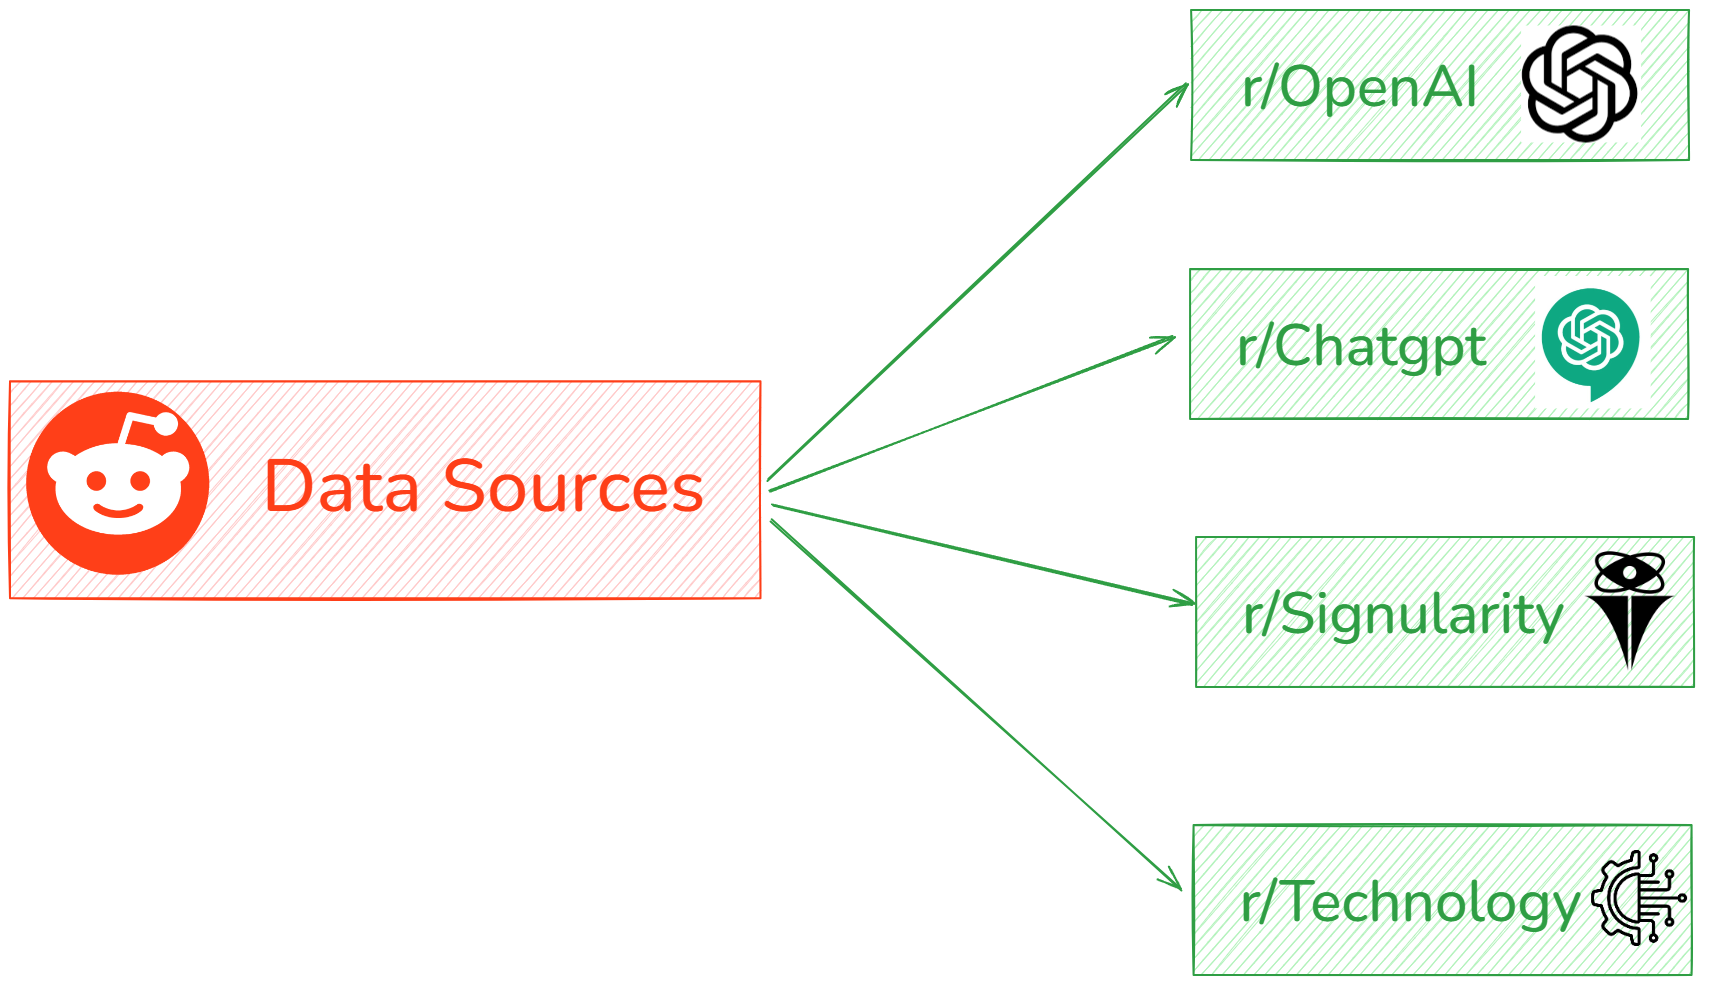

In [ ]:
import os
import asyncio
import pandas as pd
import json
import datetime
from asyncpraw import Reddit
from asyncpraw.models import MoreComments

# Load Reddit API credentials from environment variables
USERNAME = os.getenv('USER')
if not USERNAME:
    raise ValueError("USER environment variable not set")

PASSWORD = os.getenv('PASSWORD')
if not PASSWORD:
    raise ValueError("PASSWORD environment variable not set")

CLIENT_ID = os.getenv('CLIENT_ID')
if not CLIENT_ID:
    raise ValueError("CLIENT_ID environment variable not set")

CLIENT_SECRET = os.getenv('CLIENT_SECRET')
if not CLIENT_SECRET:
    raise ValueError("CLIENT_SECRET environment variable not set")


async def create_reddit_instance():
    reddit = Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent="my user agent",
        username=USERNAME,
        password=PASSWORD,
    )
    
    # Enable rate limit handling
    reddit.requestor.rate_limit_sleep = True  # Auto-handles rate-limiting
    return reddit


async def fetch_post_and_comments(reddit, post_id):
    """
    Fetches the submission and its top 10 first-level comments.
    Returns a list of dictionaries containing post and comment details.
    In case of an error, returns one dictionary with error details.
    """
    rows = []
    try:
        submission = await reddit.submission(id=post_id)
        await submission.load()
        await submission.comments.replace_more(limit=10)
        top_comments = submission.comments[:10]

        submission_details = {
            "post_id": submission.id,
            "subreddit": submission.subreddit.display_name,
            "post_title": submission.title,
            "post_body": submission.selftext,
            "number_of_comments": submission.num_comments,
            "readable_datetime": datetime.datetime.fromtimestamp(submission.created_utc).strftime("%Y-%m-%d %H:%M:%S"),
            "post_author": submission.author.name if submission.author else None,
        }

        if top_comments:
            for comment in top_comments:
                if isinstance(comment, MoreComments):  # Skip "load more" placeholders
                    continue
                row = submission_details.copy()
                row.update({
                    "comment_id": comment.id,
                    "comment_body": comment.body,
                    "number_of_upvotes": comment.score,
                    "comment_author": comment.author.name if comment.author else None,
                })
                rows.append(row)
        else:
            # No comments found; create a row with only post details
            row = submission_details.copy()
            row.update({
                "comment_id": None,
                "comment_body": None,
                "number_of_upvotes": None,
                "comment_author": None,
            })
            rows.append(row)

    except Exception as e:
        print(f"Error fetching data for post_id {post_id}: {e}")
        # Return an error row where key details (like 'subreddit') are None.
        rows.append({
            "post_id": post_id,
            "subreddit": None,
            "post_title": None,
            "post_body": None,
            "number_of_comments": None,
            "readable_datetime": None,
            "post_author": None,
            "comment_id": None,
            "comment_body": None,
            "number_of_upvotes": None,
            "comment_author": None,
        })
    
    return rows


def save_csv(data, file_name):
    """Writes the provided data (a list of dictionaries) to a CSV file."""
    df = pd.DataFrame(data)
    df.to_csv(file_name, index=False)
    print(f"CSV file saved as {file_name}")


def save_json(data, file_name):
    """Writes the provided data (a list of dictionaries) to a JSON file."""
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, default=str)
    print(f"JSON file saved as {file_name}")


async def countdown(seconds):
    """Displays a countdown timer for the given number of seconds."""
    for remaining in range(seconds, 0, -1):
        print(f"Resuming in {remaining:2d} seconds...", end="\r", flush=True)
        await asyncio.sleep(1)
    print("")  # Move to a new line after countdown


async def search_posts_by_queries(reddit, queries, subreddits, limit=5):
    """
    Searches posts for each query in the provided list within the specified subreddits.
    Returns a dictionary mapping post_id to the query (or concatenated queries) that retrieved it.
    """
    mapping = {}
    for query in queries:
        for subreddit in subreddits:
            try:
                subreddit_obj = reddit.subreddit(subreddit)
                async for submission in subreddit_obj.search(query, limit=limit):
                    pid = submission.id
                    # Append the query if this post was already retrieved by a different query.
                    if pid in mapping:
                        if query not in mapping[pid]:
                            mapping[pid] += f";{query}"
                    else:
                        mapping[pid] = query
            except Exception as e:
                print(f"Error searching for query '{query}' in subreddit '{subreddit}': {e}")
    return mapping


async def get_comment_ids(reddit, post_id, limit=10):
    """
    Retrieves a list of top-level comment IDs for the given post_id.
    """
    comment_ids = []
    try:
        submission = await reddit.submission(id=post_id)
        await submission.load()
        await submission.comments.replace_more(limit=limit)
        top_comments = submission.comments[:limit]
        for comment in top_comments:
            if isinstance(comment, MoreComments):
                continue
            comment_ids.append(comment.id)
    except Exception as e:
        print(f"Error retrieving comment ids for post_id {post_id}: {e}")
    return comment_ids


async def main():
    reddit = await create_reddit_instance()
    
    # Define your list of queries (as provided)
    queries = [
        'ChatGPT', 'Whisper', 'Operator', 'for-profit OR non-profit', 'ChatGPT vs Claude',
        'GPTs OR Custom GPTs', 'gpt OR GPT or Gpt', 'coding with ChatGPT', 'ChatGPT search',
        'OpenAI review', 'ChatGPT vs Mistral', 'Dall E', 'API pricing', 'ChatGPT review',
        'ChatGPT;gpt', 'security',
        'ChatGPT Plus OR chat gpt plus OR Chatgpt Plus OR ChatGpt plus OR ChatGpt Plus',
        'embeddings', 'ChatGPT vs Llama', 'rate limit', 'benchmark', 'quality', 'reliability',
        'privacy', 'pricing OR cost', 'ChatGPT Pro',
        'ChatGPT Pro OR chat gpt pro OR Chatgpt Pro OR ChatGpt pro OR ChatGpt PRO',
        'performance', 'Dall E OR dall e', 'GPT 4 review',
        'availability OR downtime OR outage', 'speed', 'open-source OR closed-source',
        'ChatGPT Enterprise', 'GPT 3 review', 'subscription OR ChatGPT plus', 'ChatGPT vs DeepSeek',
        'OpenAI', 'code', 'ChatGPT canvas', 'review', 'latency', 'GPT 3.5 review', 'mini',
        'GPT 3.5 Turbo review', 'gpt', 'o3', 'privacy;code',
        'ChatGPT PRO OR chat gpt pro OR Chatgpt Pro OR ChatGpt pro OR ChatGpt Pro',
        'ChatGPT vs Gemini', 'o1', 'ChatGPT vs Deepseek',
        'GPT 3.5 OR GPT 3.5 Turbo OR gpt-3.5 OR gpt-3.5-turbo', 'Sora',
        'GPT-4o OR GPT 4o OR  gpt4o OR gpt 4o', 'GPT 4o review',
        'GPT-4o AND GPT 4o AND  gpt4o AND gpt 4o', 'ChatGPT;ChatGPT vs Claude',
        'GPT-4o mini OR GPT 4o mini OR gpt 4o mini', 'ChatGPT vs Qwen',
        'O1 OR o1', 'o1 mini review',
        'GPT-4o mini OR GPT 4o mini OR gpt 4o mini;ChatGPT Plus OR chat gpt plus OR Chatgpt Plus OR ChatGpt plus OR ChatGpt Plus',
        'ChatGPT;ChatGPT vs DeepSeek', 'ChatGPT;ChatGPT search',
        'ChatGPT vs Qwen;ChatGPT Plus OR chat gpt plus OR Chatgpt Plus OR ChatGpt plus OR ChatGpt Plus',
        'ChatGPT;OpenAI', 'mini', 'reliability'
    ]
    
    # Define the target subreddits for the search
    subreddits = ["OpenAI", "singularity", "ChatGPT", "technology"]
    
    # Build a mapping of post IDs to queries by searching Reddit
    post_query_mapping = await search_posts_by_queries(reddit, queries, subreddits, limit=5)
    all_post_ids = list(post_query_mapping.keys())
    print(f"Total unique posts found from search: {len(all_post_ids)}")
    
    # Check for an existing checkpoint (processed post_ids)
    checkpoint_file = "checkpoint.json"
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, "r", encoding="utf-8") as f:
            processed_ids = json.load(f)
        print(f"Resuming from checkpoint: {len(processed_ids)} posts already processed.")
    else:
        processed_ids = []

    # Only process posts that have not yet been processed.
    to_process_all = [post_id for post_id in all_post_ids if post_id not in processed_ids]
    print(f"Total posts to process: {len(to_process_all)}")

    # Maintain a retry counter for each post.
    retries = {post_id: 0 for post_id in to_process_all}
    max_retries = 3  # Maximum attempts per post
    batch_size = 30  # Number of posts to process per mini-batch

    # Define output file names.
    output_csv = "raw_dataset.csv"
    output_json = "raw_dataset.json"

    # If output files already exist, load their data; otherwise, start with an empty list.
    if os.path.exists(output_csv):
        existing_df = pd.read_csv(output_csv)
        output_data = existing_df.to_dict(orient="records")
    else:
        output_data = []

    while to_process_all:
        print(f"\nStarting a round with {len(to_process_all)} posts to process.")
        next_to_process = []  # To hold posts that need to be retried

        # Process posts in mini-batches.
        for i in range(0, len(to_process_all), batch_size):
            batch_ids = to_process_all[i:i+batch_size]
            print(f"\nProcessing mini-batch {i // batch_size + 1} "
                  f"of {((len(to_process_all)-1) // batch_size) + 1} (posts: {batch_ids})")
            
            tasks = [fetch_post_and_comments(reddit, post_id) for post_id in batch_ids]
            results = await asyncio.gather(*tasks)
            
            for post_id, rows in zip(batch_ids, results):
                # If the first row's "subreddit" is None, assume an error occurred.
                if rows and rows[0]["subreddit"] is None:
                    retries[post_id] += 1
                    if retries[post_id] < max_retries:
                        print(f"Error for post_id {post_id}; retrying (attempt {retries[post_id]}/{max_retries}).")
                        next_to_process.append(post_id)
                    else:
                        print(f"Error for post_id {post_id} after {max_retries} attempts; logging error.")
                        for row in rows:
                            row["query"] = post_query_mapping.get(post_id, "")
                        output_data.extend(rows)
                        processed_ids.append(post_id)
                else:
                    # Successful result.
                    for row in rows:
                        row["query"] = post_query_mapping.get(post_id, "")
                    output_data.extend(rows)
                    processed_ids.append(post_id)
            
            # Incrementally save output after each mini-batch.
            save_csv(output_data, output_csv)
            save_json(output_data, output_json)
            # Update the checkpoint.
            with open(checkpoint_file, "w", encoding="utf-8") as f:
                json.dump(processed_ids, f, indent=4)
            
            print("Mini-batch processed. Waiting 60 seconds before the next mini-batch...")
            await countdown(60)

        if next_to_process:
            print(f"\nRetrying {len(next_to_process)} posts in the next round...\n")
            to_process_all = next_to_process
        else:
            break

    print("All posts processed.")


In [4]:
import nest_asyncio
nest_asyncio.apply()

async def run_async():
    await main()

await run_async()

C:\Users\User\AppData\Local\Temp\ipykernel_34020\1641351664.py:47: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Total posts to process: 9575

Starting a round with 9575 posts to process.

Processing mini-batch 1 of 320 (posts: [' the next era is the niche content producer who produces high quality video content', '1002dom', '1007cpq', '100ayoe', '100ye6s', '101chgd', '101melg', '101ms83', '101o6zx', '101p00n', '102ci8x', '102jcse', '102l28b', '102lbp8', '102lrwi', '102xqim', '1030pti', '1030xji', '1031mz4', '1031yi2', '10346f5', '1035gzm', '103ahhi', '103gran', '103qc9j', '103vj6v', '103w7m4', '103wsie', '103yg7r', '1041tuw'])
Error fetching data for post_id  the next era is the niche content producer who produces high quality video content: received 404 HTTP response
Error fetching data for post_id 1030xji: received 429 HTTP response
Error for post_id  the next era is the niche content producer who produces high quality video content; retrying (attempt 1/3).
Error for post_id 1030xji; retrying (attempt 1/3).
CSV file saved as new_combined_dataset.csv
JSON file saved as new_combined_dataset.json

### Raw-Data Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys

In [ ]:
# Load dataset

if 'google.colab' in sys.modules:
    df = pd.read_csv("drive/My Drive/AA/raw_dataset.csv")
else:
    df = pd.read_csv("Data/raw_dataset.csv")


#### Basic Information

In [4]:
# Display basic information
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54966 entries, 0 to 54965
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   post_id             54966 non-null  object 
 1   subreddit           54954 non-null  object 
 2   post_title          54954 non-null  object 
 3   post_body           30349 non-null  object 
 4   number_of_comments  54954 non-null  float64
 5   readable_datetime   54954 non-null  object 
 6   post_author         54478 non-null  object 
 7   comment_id          54352 non-null  object 
 8   comment_body        54350 non-null  object 
 9   number_of_upvotes   54352 non-null  float64
 10  comment_author      49478 non-null  object 
 11  query               52113 non-null  object 
dtypes: float64(2), object(10)
memory usage: 5.0+ MB


In [5]:
# Sample records
print("\nSample Records:")
display(df.head())


Sample Records:


,post_id,subreddit,post_title,post_body,number_of_comments,readable_datetime,post_author,comment_id,comment_body,number_of_upvotes,comment_author,query
0,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2far1e,Chat GPT wrote this article ffs,792.0,The_Bridge_Imperium,ChatGPT
1,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f5vg2,Did you order the code red?,687.0,damienn22,ChatGPT
2,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f9y5m,If my search engine was littered with SEO keyw...,1288.0,1x2x4x1,ChatGPT
3,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f7njc,How many more times are we gonna see this story,306.0,frombaktk,ChatGPT
4,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2fna2c,How far can we trust ChatGPT? It's very intere...,70.0,Milk_Busters,ChatGPT


In [6]:
# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
post_id                   0
subreddit                12
post_title               12
post_body             24617
number_of_comments       12
readable_datetime        12
post_author             488
comment_id              614
comment_body            616
number_of_upvotes       614
comment_author         5488
query                  2853
dtype: int64


In [7]:
# Basic statistics
df["post_title_length"] = df["post_title"].astype(str).apply(len)
df["post_body_length"] = df["post_body"].astype(str).apply(len)
df["comment_body_length"] = df["comment_body"].astype(str).apply(len)

# Unique vs. Duplicate text
unique_titles = df["post_title"].nunique()
unique_bodies = df["post_body"].nunique()
unique_comments = df["comment_body"].nunique()

print("\nUnique vs Duplicate Counts:")
print(f"Unique Post Titles: {unique_titles}/{len(df)}")
print(f"Unique Post Bodies: {unique_bodies}/{len(df)}")
print(f"Unique Comments: {unique_comments}/{len(df)}")



Unique vs Duplicate Counts:
Unique Post Titles: 9426/54966
Unique Post Bodies: 5793/54966
Unique Comments: 51594/54966


#### Charecter Length

In [8]:
# Summary statistics for text lengths = BASED ON CHARECTERS
text_length_stats = pd.DataFrame({
    "Metric": ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"],
    "Post Title Length": [
        df["post_title_length"].min(),
        df["post_title_length"].quantile(0.25),
        df["post_title_length"].median(),
        df["post_title_length"].quantile(0.75),
        df["post_title_length"].max(),
        df["post_title_length"].mean(),
    ],
    "Post Body Length": [
        df["post_body_length"].min(),
        df["post_body_length"].quantile(0.25),
        df["post_body_length"].median(),
        df["post_body_length"].quantile(0.75),
        df["post_body_length"].max(),
        df["post_body_length"].mean(),
    ],
    "Comment Body Length": [
        df["comment_body_length"].min(),
        df["comment_body_length"].quantile(0.25),
        df["comment_body_length"].median(),
        df["comment_body_length"].quantile(0.75),
        df["comment_body_length"].max(),
        df["comment_body_length"].mean(),
    ],
})

# Display the table in a Jupyter Notebook-friendly format
from IPython.display import display
display(text_length_stats)


,Metric,Post Title Length,Post Body Length,Comment Body Length
0,Min,1.000000,1.000000,1.000000
1,25th Percentile,41.000000,3.000000,51.000000
2,Median (50th),63.000000,100.000000,118.000000
3,75th Percentile,94.000000,676.000000,274.000000
4,Max,300.000000,36834.000000,9996.000000
5,Mean,76.353036,745.767129,240.651002


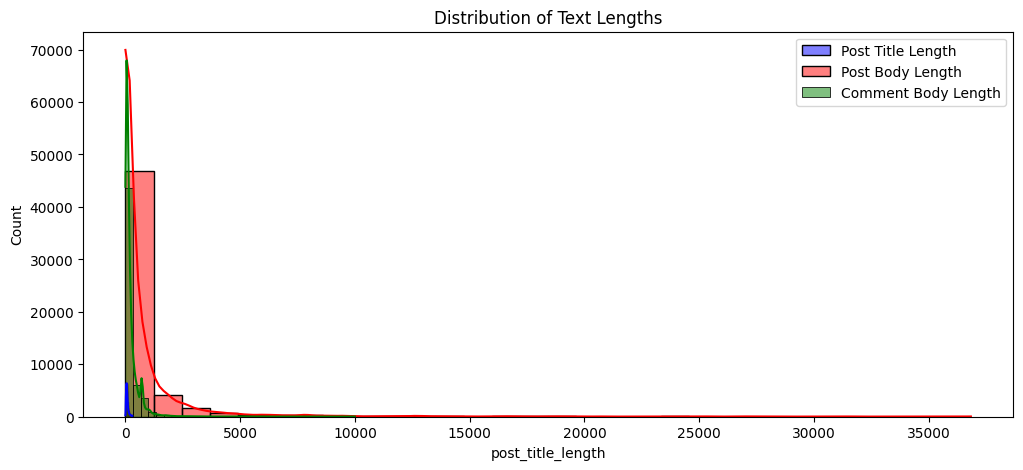

In [9]:
# Plot distribution of text lengths
plt.figure(figsize=(12, 5))
sns.histplot(df["post_title_length"], bins=30, kde=True, color='blue', label="Post Title Length")
sns.histplot(df["post_body_length"], bins=30, kde=True, color='red', label="Post Body Length")
sns.histplot(df["comment_body_length"], bins=30, kde=True, color='green', label="Comment Body Length")
plt.legend()
plt.title("Distribution of Text Lengths")
plt.show()

#### Word Length

In [10]:
df["post_title_word_count"] = df["post_title"].astype(str).apply(lambda x: len(x.split()))
df["post_body_word_count"] = df["post_body"].astype(str).apply(lambda x: len(x.split()))
df["comment_body_word_count"] = df["comment_body"].astype(str).apply(lambda x: len(x.split()))

# Summary statistics for word counts
word_count_stats = pd.DataFrame({
    "Metric": ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"],
    "Post Title Word Count": [
        df["post_title_word_count"].min(),
        df["post_title_word_count"].quantile(0.25),
        df["post_title_word_count"].median(),
        df["post_title_word_count"].quantile(0.75),
        df["post_title_word_count"].max(),
        df["post_title_word_count"].mean(),
    ],
    "Post Body Word Count": [
        df["post_body_word_count"].min(),
        df["post_body_word_count"].quantile(0.25),
        df["post_body_word_count"].median(),
        df["post_body_word_count"].quantile(0.75),
        df["post_body_word_count"].max(),
        df["post_body_word_count"].mean(),
    ],
    "Comment Body Word Count": [
        df["comment_body_word_count"].min(),
        df["comment_body_word_count"].quantile(0.25),
        df["comment_body_word_count"].median(),
        df["comment_body_word_count"].quantile(0.75),
        df["comment_body_word_count"].max(),
        df["comment_body_word_count"].mean(),
    ],
})

# Display the table
display(word_count_stats)

,Metric,Post Title Word Count,Post Body Word Count,Comment Body Word Count
0,Min,1.000000,0.000000,1.00000
1,25th Percentile,7.000000,1.000000,9.00000
2,Median (50th),11.000000,12.000000,20.00000
3,75th Percentile,16.000000,109.000000,47.00000
4,Max,58.000000,5815.000000,1815.00000
5,Mean,13.105593,117.701925,39.56393


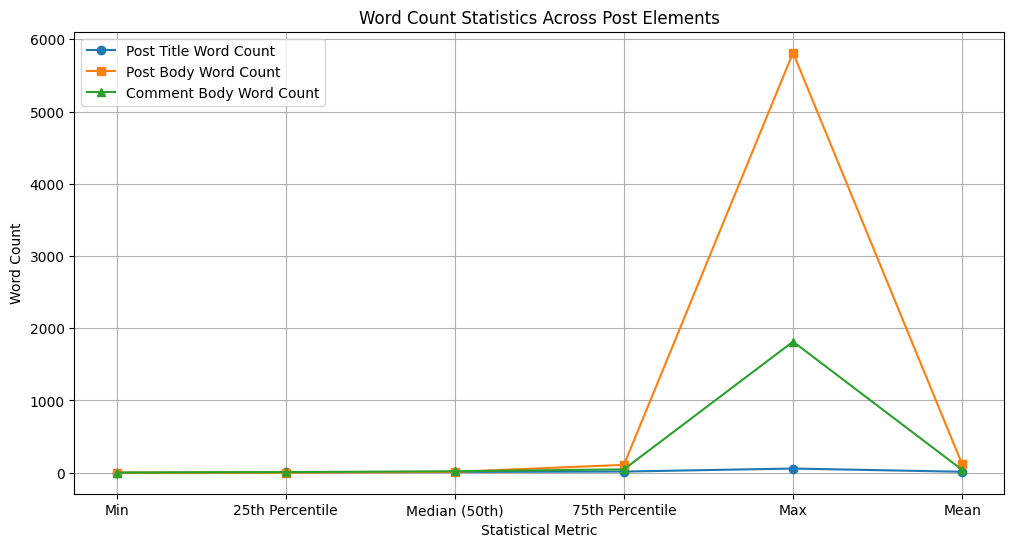

In [11]:
# Define the metrics for x-axis
metrics = ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"]
x_labels = range(len(metrics))  # X-axis positions

# Create a figure for word count statistics
plt.figure(figsize=(12, 6))

# Plot lines for each text category
plt.plot(x_labels, word_count_stats["Post Title Word Count"], marker="o", label="Post Title Word Count")
plt.plot(x_labels, word_count_stats["Post Body Word Count"], marker="s", label="Post Body Word Count")
plt.plot(x_labels, word_count_stats["Comment Body Word Count"], marker="^", label="Comment Body Word Count")

# Formatting the plot
plt.xticks(x_labels, metrics)  # Set x-axis labels
plt.ylabel("Word Count")
plt.xlabel("Statistical Metric")
plt.title("Word Count Statistics Across Post Elements")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


#### Sample Data

In [24]:
# Show some examples
print("\nSample Posts and Comments:")
sample_data = df[["post_title", "post_body", "comment_body"]].sample(10, random_state=42)
display(sample_data)


Sample Posts and Comments:


,post_title,post_body,comment_body
47632,AI models now outperform PhD experts in their ...,NaN,I love how he just adds 'exponential' to what ...
28105,Due to the speed of AI development and the lon...,NaN,Academic papers run the gamut from top notch i...
22395,Brad Lightcap (an OpenAI executive) just said ...,https://x.com/legit_rumors/status/178768158049...,So we're getting a great teammate in 12 months...
47673,My 100% human written paragraph was flagged as...,"Many online forms right now, oblige you not to...",This AI Detector is not commonly used. Use som...
54365,"hey guys, it says open A.I is not available in...",But my country is in the Philippines but I cur...,"If you have access to the app telegram, there'..."
10151,Is it me or does Dall-E 3 not produce realisti...,NaN,It’s amazing to be honest
54660,ChatGPT PRO app in the Play Store: Is this legit?,NaN,This doesn't look like something done by OpenA...
3184,OpenAI will discontinue support for their Code...,NaN,Cool - now I can close the tab I had open in m...
19962,GPT-3.5-turbo doesn't complete task,I'm experimenting with API calls to `GPT-3.5-t...,GPT 3.5 has reached its full teenage potential…
1566,Sydney (Bing GPT) is scarily similar to Samant...,\n\nWhen New Bing was announced on the 7th of...,We need waifuGPT


#### Frequency Analysis

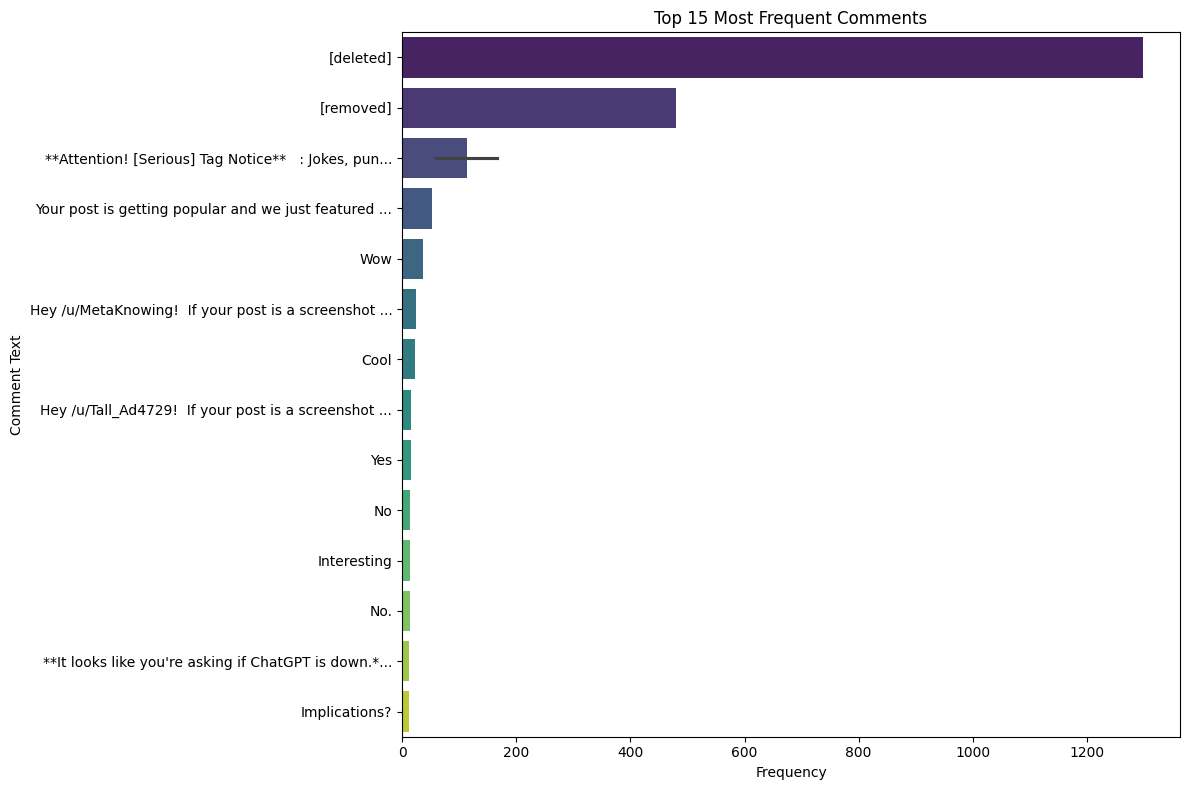

In [30]:
from tabulate import tabulate

# Convert frequency counts to a percentage of total comments
comment_freq = df['comment_body'].value_counts().reset_index()

def clean_comment(comment):
    c = comment.replace('\n', ' ').strip()
    if len(c) > 50:
        return c[:50] + '...'
    return c

# Create a nicely formatted table for display
freq_table = pd.DataFrame({
    'Comment Text': comment_freq['comment_body'].apply(clean_comment),
    'Count': comment_freq['count'],
}).head(15)

# Plot the horizontal bar chart for the top 15 comments
plt.figure(figsize=(12, 8))
sns.barplot(data=freq_table, 
            x='Count', 
            y='Comment Text',
            hue='Comment Text',  
            legend=False, 
            palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Comment Text')
plt.title('Top 15 Most Frequent Comments')
plt.tight_layout()
plt.show()

In [45]:
# Check if there are any non standard Post IDs or Comment IDs

# Standard lenght of the IDs are 6 or 7 characters
# They contain only lowercase letters and digits

# Check for non-standard post IDs (handling NaN values)
non_standard_post_ids = df[~df['post_id'].fillna('').str.match(r'^[a-z0-9]{6,7}$')]  # Regex pattern for post IDs

# Check for non-standard comment IDs (handling NaN values)
non_standard_comment_ids = df[~df['comment_id'].fillna('').str.match(r'^[a-z0-9]{6,7}$')]  # Regex pattern for comment IDs

# Display the counts and post IDs
print("Non-Standard Post IDs:")
print("Count: ", len(non_standard_post_ids))
post_id_df = pd.Series(non_standard_post_ids['post_id'].unique(), name='Post IDs').to_frame()
print(tabulate(post_id_df, headers='keys', tablefmt='psql', showindex=False))

# Display the counts and comment IDs
print("\nNon-Standard Comment IDs:")
print("Count: ", len(non_standard_comment_ids))
comment_id_df = pd.Series(non_standard_comment_ids['comment_id'].unique(), name='Comment IDs').to_frame()
print(tabulate(comment_id_df, headers='keys', tablefmt='psql', showindex=False))



Non-Standard Post IDs:
Count:  12
+------------------------------------------------------------------------------------------------------------------------+
| Post IDs                                                                                                               |
|------------------------------------------------------------------------------------------------------------------------|
| magic                                                                                                                  |
| e22d6                                                                                                                  |
| the next era is the niche content producer who produces high quality video content                                     |
| 24-01-02 02:13:56                                                                                                      |
| > Yet when you watch movies that were shot somewhere between the 50s and the 90s                       

<Figure size 1200x600 with 0 Axes>

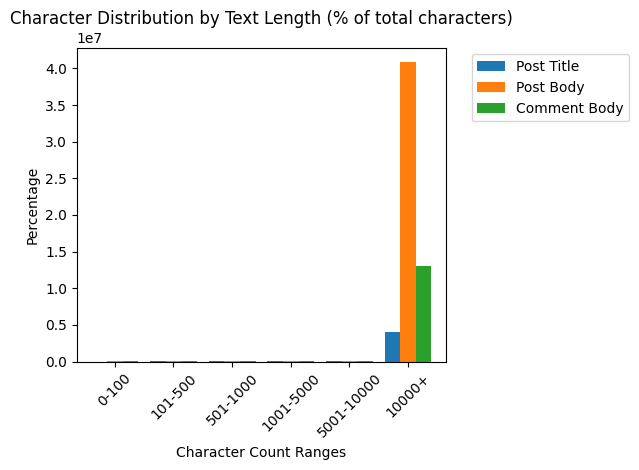

Post Title Character Counts:
count       276.000000
mean      15205.742754
std       59881.758329
min           1.000000
25%           2.000000
50%          11.000000
75%        1239.250000
max      668322.000000
dtype: float64

Post Body Character Counts:
count    5.870000e+02
mean     6.970696e+04
std      4.057647e+05
min      1.000000e+00
25%      9.000000e+00
50%      2.000000e+01
75%      6.750000e+01
max      6.353841e+06
dtype: float64

Comment Body Character Counts:
count    1.060000e+03
mean     1.247715e+04
std      9.990402e+04
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      2.104264e+06
dtype: float64


In [53]:
# Define bins for character counts
bins = [0, 100, 500, 1000, 5000, 10000, float('inf')]
labels = ['0-100', '101-500', '501-1000', '1001-5000', '5001-10000', '10000+']

# Count characters for each text field
post_title_chars = Counter(''.join(df['post_title'].fillna('')))
post_body_chars = Counter(''.join(df['post_body'].fillna('')))
comment_body_chars = Counter(''.join(df['comment_body'].fillna('')))

# Function to bin the character counts
def bin_counts(counter):
    binned = {label: 0 for label in labels}
    
    for _, count in counter.items():
        for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
            if lower <= count < upper:
                binned[labels[i]] += count
                break
                
    return pd.Series(binned)

# Bin the character counts
binned_counts = pd.DataFrame({
    'Post Title': bin_counts(post_title_chars),
    'Post Body': bin_counts(post_body_chars),
    'Comment Body': bin_counts(comment_body_chars)
})

# Create the plot
plt.figure(figsize=(12, 6))
binned_counts.plot(kind='bar', width=0.8)
plt.title('Character Distribution by Text Length (% of total characters)')
plt.xlabel('Character Count Ranges')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


# Print the quartiles for the character counts
print("Post Title Character Counts:")
print(pd.Series(post_title_chars).describe(percentiles=[0.25, 0.5, 0.75]))
print("\nPost Body Character Counts:")
print(pd.Series(post_body_chars).describe(percentiles=[0.25, 0.5, 0.75]))
print("\nComment Body Character Counts:")
print(pd.Series(comment_body_chars).describe(percentiles=[0.25, 0.5, 0.75]))

#### Data Insights

1) Volume and Engagement
    - Dataset contains 54,966 total records
    - 9,426 unique post titles and 51,594 unique comments
    - Only 5,793 unique post bodies, indicating significant content reuse
    - Average of ~39 words per comment, showing concise engagement

2) Content Patterns
    - High percentage of deleted/removed content (1,298 deleted, 480 removed comments)
    - Significant number of automated messages and moderator notices
    - Common short responses like "Wow", "Cool", "Yes" appear frequently

3) Data Quality Issues
    - Some non-standard post IDs identified
    - Missing values in various fields (comment_author, post_body)
    - Presence of automated messages and system notifications affecting data quality
    - Mismatch in No.of missing comment ids and comment bodies

4) Word Count Analysis
    - Post titles: Average of 13 words
    - Post bodies: Average of 118 words
    - Comments: Average of 40 words
    - Shows preference for concise titles and longer post content

5) Distribution Analysis
    - Most text content falls in the 1000+ character range
    - Over 40M characters in post bodies, indicating lengthy discussions
    - Roughly 13M characters in comments, showing substantial engagement
    - Post titles remain concise with most under 1000 characters
    - Comment distribution shows moderate length preferences (500-10000 characters)

# Data Preprocessing

#### Clean data

1) Quality Control
    - Remove records with non-standard post IDs (6-7 characters)
    - Remove records where subreddit is null
    - Clean text formatting:
      - Replace newlines with spaces
      - Re-encode to UTF-8 to handle special characters

2) Text Preprocessing
    - Fill missing values in number_of_upvotes with 0
    - Remove deleted/removed comments
    - Remove comments that appear more than 50 times (likely automated/spam)
    - Remove automated messages matching patterns:
      - Username mentions ("Hey /u/...")
      - Moderation notices
      - Reddit removal notices
      - Text in square brackets

In [ ]:
if 'google.colab' in sys.modules:
    filtered_data = pd.read_csv("drive/My Drive/AA/raw_dataset.csv")
else:
    filtered_data = pd.read_csv("Data/raw_dataset.csv")

In [ ]:
# Ensure that the post_id is 6 or 7 characters long
filtered_data = filtered_data[filtered_data['post_id'].str.match(r'^[a-z0-9]{6,7}$')]

# Remove all records where subreddit is null
filtered_data = filtered_data[~filtered_data['subreddit'].isnull()]

filtered_data['post_title'] = filtered_data['post_title'].str.replace('\n', ' ')
filtered_data['post_body'] = filtered_data['post_body'].str.replace('\n', ' ')
filtered_data['comment_body'] = filtered_data['comment_body'].str.replace('\n', ' ')

# Reencode the data to utf-8
filtered_data['post_title'] = filtered_data['post_title'].str.encode('utf-8', 'ignore').str.decode('utf-8')
filtered_data['post_body'] = filtered_data['post_body'].str.encode('utf-8', 'ignore').str.decode('utf-8')
filtered_data['comment_body'] = filtered_data['comment_body'].str.encode('utf-8', 'ignore').str.decode('utf-8')

filtered_data['number_of_upvotes'] = filtered_data['number_of_upvotes'].fillna(0)

# Fill empty post_body 
filtered_data['post_body'] = filtered_data['post_body'].fillna('')

# Remove where comment_body is [deleted] or [removed]
filtered_data = filtered_data[filtered_data['comment_body'] != '[deleted]']
filtered_data = filtered_data[filtered_data['comment_body'] != '[removed]']

# Remove comment body when count is greater than 50
# Keep records where comment_body is null or appears <= 50 times
# Create a mask for records where comment_body is null or appears <= 50 times
comment_counts = filtered_data['comment_body'].value_counts()
mask = (filtered_data['comment_body'].isna()) | (filtered_data['comment_body'].map(lambda x: comment_counts.get(x, 0) <= 50))
filtered_data = filtered_data[mask]

# Remove data that matches the regex pattern, handling NaN values
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'^Hey\s+/u/\w+.*?$', regex=True)]
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'^.*?if you have any questions or concerns.*?$', regex=True)]
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'\[ Removed by Reddit \]', regex=True)]
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'^.*?\[.*?\].*?$', regex=True)]

# # Store the data in a new CSV file
# filtered_data.to_csv('cleaned_data.csv', index=False)

# Check number post (has post_id but no comment_id)
print("\nAfter cleaning the data")
print("Number of posts:", len(filtered_data['post_id'].unique()))
print("Posts without comments:", len(filtered_data[filtered_data['comment_id'].isna()]))



After cleaning the data
Number of posts: 8850
Posts without comments: 602


Fix the data category of each field

In [116]:
# Declare each field data type
filtered_data['post_id'] = filtered_data['post_id'].astype(str)
filtered_data['comment_id'] = filtered_data['comment_id'].astype(str)
filtered_data['post_title'] = filtered_data['post_title'].astype(str)
filtered_data['post_body'] = filtered_data['post_body'].astype(str)
filtered_data['post_author'] = filtered_data['post_author'].astype(str)
filtered_data['comment_body'] = filtered_data['comment_body'].astype(str)
filtered_data['comment_author'] = filtered_data['comment_author'].astype(str)
filtered_data['query'] = filtered_data['query'].astype(str)

filtered_data['subreddit'] = filtered_data['subreddit'].astype('category')
filtered_data['query'] = filtered_data['query'].astype('category')

# Fill NaN values with 0 before converting to int
filtered_data['number_of_comments'] = filtered_data['number_of_comments'].fillna(0).astype(int)
filtered_data['number_of_upvotes'] = filtered_data['number_of_upvotes'].fillna(0).astype(int)

filtered_data['readable_datetime'] = pd.to_datetime(filtered_data['readable_datetime'])

print(filtered_data.head())


   post_id   subreddit                                        post_title  \
0  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
1  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
2  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
3  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
4  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   

  post_body  number_of_comments   readable_datetime post_author comment_id  \
0                           370 2023-01-01 00:03:33    slakmehl    j2far1e   
1                           370 2023-01-01 00:03:33    slakmehl    j2f5vg2   
2                           370 2023-01-01 00:03:33    slakmehl    j2f9y5m   
3                           370 2023-01-01 00:03:33    slakmehl    j2f7njc   
4                           370 2023-01-01 00:03:33    slakmehl    j2fna2c   

                                        comment_body  number_of_upvotes  \

#### Data consolidation

1. Text Combination
- Created combined text field from comment bodies or Post tite + Post body
- Replaced None/NaN values with empty strings
- Dropped rows with empty text
- Added new rows for unique posts
- Removed duplicate rows

2. Filter by Date
- Imported datetime utilities
- Set cutoff date to 5 years from current date
- Filtered data to only include posts within date range 
- Validated date range of filtered data

3. Text Length Processing
- Removed records with empty/missing text
- Established minimum word count threshold of 3 words
- Calculated word count statistics
- Set maximum word threshold using upper quartile + 1.5*IQR
- Filtered data to include only texts within word count bounds
- Remove Texts above 1024 chars for Embedding Model (iterative descision)

In [117]:
# Create combined text field and replace None/NaN with empty string
filtered_data["text"] = filtered_data.apply(
	lambda row: (
		str(row['comment_body']).strip() if pd.notna(row['comment_body'])
		else ""), 
	axis=1
).fillna("")

# Print count
print("Number of empty texts:", (filtered_data["text"] == "").sum())
print("Number of NA texts:", filtered_data["text"].isna().sum())
print("Total records:", len(filtered_data))

# Drop rows where text is empty
filtered_data = filtered_data[filtered_data["text"] != ""]

# Add a new row for all unique posts (get post_id, comments, and all from first record of the post, exclude any comment fields)
posts = filtered_data.groupby("post_id").first().reset_index()
posts = posts.drop(columns=["comment_id", "comment_body", "comment_author", "text"])

print("\nNumber of posts:", len(posts))

# Make post text the same as post title and post body
posts["text"] = posts["post_title"] + " " + posts["post_body"]

# Concat filtered data and posts
filtered_data = pd.concat([posts, filtered_data], ignore_index=True)

# Remove any duplicate rows
filtered_data = filtered_data.drop_duplicates()

# Display first few rows and value counts of empty strings
print("\nAfter adding new row for all unique posts")
print("Total records:", len(filtered_data))

Number of empty texts: 0
Number of NA texts: 0
Total records: 48389

Number of posts: 8850

After adding new row for all unique posts
Total records: 57239


In [118]:
# No.of Posts and Comments
print("\nStats:")
print("Total Records:", len(filtered_data))
print("Total Posts:", len(filtered_data["post_id"].unique()))
print("Total Comments:", len(filtered_data["comment_id"].unique()))


Stats:
Total Records: 57239
Total Posts: 8850
Total Comments: 47789


###  S1: Filter to past 5 year

In [119]:
from datetime import datetime, timedelta

In [120]:
cutoff_date = datetime.now() - timedelta(days=5*365)

filtered_data = filtered_data[filtered_data["readable_datetime"] > cutoff_date]

print("\nNumber of Posts and Comments after filtering:")
print(filtered_data["post_id"].nunique())
print(filtered_data["comment_id"].count())

# Print date time range in the data
print("\nDate time range:")
print(filtered_data["readable_datetime"].min())
print(filtered_data["readable_datetime"].max())


Number of Posts and Comments after filtering:
8834
48355

Date time range:
2020-05-01 13:26:05
2025-01-30 12:00:03


In [121]:
# Remove all missing records where text is empty
filtered_data = filtered_data[filtered_data["text"] != ""]
filtered_data = filtered_data[filtered_data["text"].notna()]
filtered_data = filtered_data[filtered_data["text"] != "nan"]
filtered_data = filtered_data[filtered_data["text"] != "None"]

### S2: Text Length

Short Texts: Extremely short texts (e.g., those with only one or two words) might not provide enough context and could be noise.

Excessively Long Texts: Conversely, texts that far exceed the typical length for your domain might be off-topic or contain noise.

In [122]:
min_words = 3

# Calculate word counts for each text
word_counts = filtered_data['text'].str.split().str.len()

print("\nWord count statistics:")
print(tabulate([word_counts.describe()], headers='keys'))
print("\n")


# Set max_words as the upper quartile (75th percentile) plus 1.5 times IQR
Q3 = word_counts.quantile(0.75)
Q1 = word_counts.quantile(0.25)
IQR = Q3 - Q1
max_words = int(Q3 + 1.5 * IQR)

print(f"Max words set to: {max_words}")


Word count statistics:
  count    mean      std    min    25%    50%    75%    max
-------  ------  -------  -----  -----  -----  -----  -----
  56592   52.46  141.864      1     10     21     49   5827


Max words set to: 107


In [123]:
print("\nNumber of Posts and Comments before filtering by word count:")
print("Posts:", filtered_data["post_id"].nunique())
print("Comments:", filtered_data["comment_id"].nunique())

# First recalculate word counts since filtered_data has been modified since last count
word_counts = filtered_data['text'].str.split().str.len()

# Store the initial number of records
initial_records = len(filtered_data)

# Filter based on min and max words
filtered_data = filtered_data[word_counts.between(min_words, max_words)]

# Calculate the number of records removed
records_removed = initial_records - len(filtered_data)

print("\nNumber of Posts and Comments after filtering by word count:")
print("Posts:", filtered_data["post_id"].nunique())
print("Comments:", filtered_data["comment_id"].nunique())
print("\nNumber of records removed:", records_removed)


Number of Posts and Comments before filtering by word count:
Posts: 8834
Comments: 47758

Number of Posts and Comments after filtering by word count:
Posts: 8573
Comments: 42711

Number of records removed: 7723



Character length statistics:
  count     mean      std    min    25%    50%    75%    max
-------  -------  -------  -----  -----  -----  -----  -----
  48869  160.769  152.786      7     57    111    220  12475


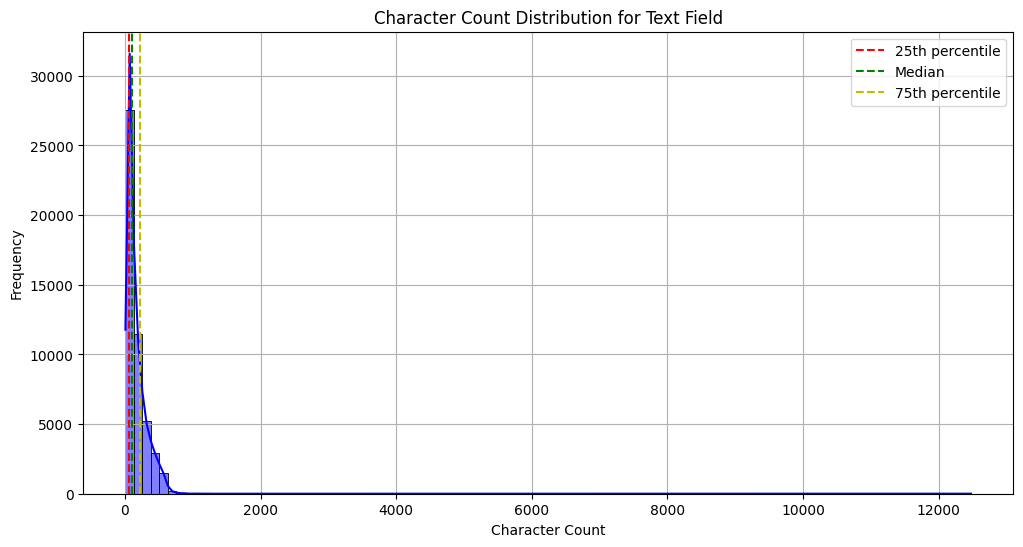

In [124]:
# Calculate character lengths
char_lengths = filtered_data['text'].str.len()

# Plot the character length distribution
plt.figure(figsize=(12, 6))
sns.histplot(char_lengths, bins=100, kde=True, color='blue')
plt.title('Character Count Distribution for Text Field')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)

# Add vertical lines for quartiles
plt.axvline(char_lengths.quantile(0.25), color='r', linestyle='--', label='25th percentile')
plt.axvline(char_lengths.quantile(0.5), color='g', linestyle='--', label='Median')
plt.axvline(char_lengths.quantile(0.75), color='y', linestyle='--', label='75th percentile')
plt.legend()


# Print results in tabular format
print("\nCharacter length statistics:")
print(tabulate([char_lengths.describe()], headers='keys'))

In [125]:
# print records exceeding 1024 characters
print("\nRecords exceeding 1024 characters:")

limit_exceeded = filtered_data[char_lengths > 1024]

print("No.of Records Exceeding 1024 Characters:", len(limit_exceeded))

# Display the first few records
print(limit_exceeded['text'])


Records exceeding 1024 characters:
No.of Records Exceeding 1024 Characters: 16
316      Beginners tutorial on using OpenAI DALLE with ...
626      Application error: a client-side exception has...
953      Microsoft announces new tool for applying Chat...
1029     Claims about the capabilities of open source L...
1366     Correctly using generative AI models: foundati...
1474     Who's worried that Gemini is going to be/get s...
1740     I think I got access to DALL-E 3, it's incredi...
1966     New API GPT-4 Turbo 128K Context and API Code ...
2043     I have been fascinated to see that ChatGPT dis...
2622     Anthropic updates it terms of use today. Seem ...
7498     ChatGPT o1-mini is silently getting nerfed aga...
8038     How many places can ChatGPT calculate Pi? Aske...
8435     DeepSeek is much smarter than it's content-fil...
8771     text-embedding-ada-002    * **Better:** it out...
11058    Looks like you already found the "add a delay"...
13108    Be gone crap.  &#x200B;  r

In [126]:
# Remove records where text exceeds 1024 characters
filtered_data = filtered_data[char_lengths <= 1024]

# Display the number of records after filtering
print("\nNumber of Posts and Comments after filtering by character count:")
print("Posts:", filtered_data["post_id"].nunique())
print("Comments:", filtered_data["comment_id"].nunique())
print("\nNumber of records removed:", len(limit_exceeded))
print("\nTotal records:", len(filtered_data))


Number of Posts and Comments after filtering by character count:
Posts: 8571
Comments: 42709

Number of records removed: 16

Total records: 48853


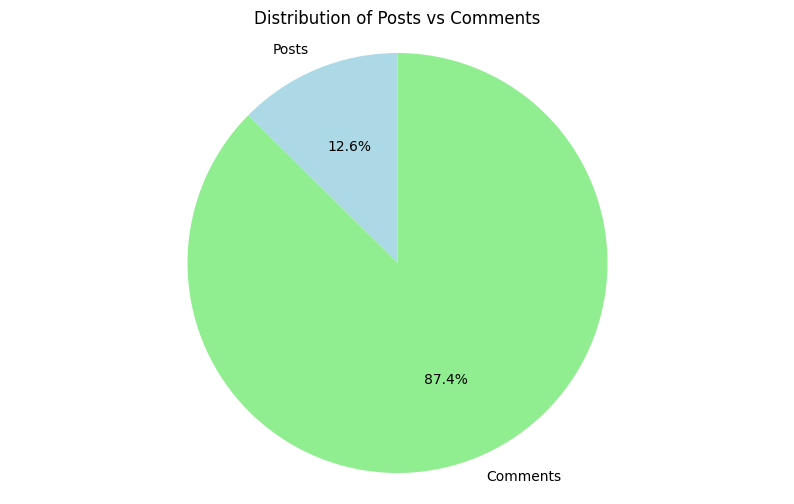

In [127]:
# Count posts vs comments from post_or_comment column
# Create a Series for posts vs comments distribution
data = pd.Series({
    'Posts': filtered_data["comment_id"].isna().sum(),
    'Comments': filtered_data["comment_id"].notna().sum()
})

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title("Distribution of Posts vs Comments")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

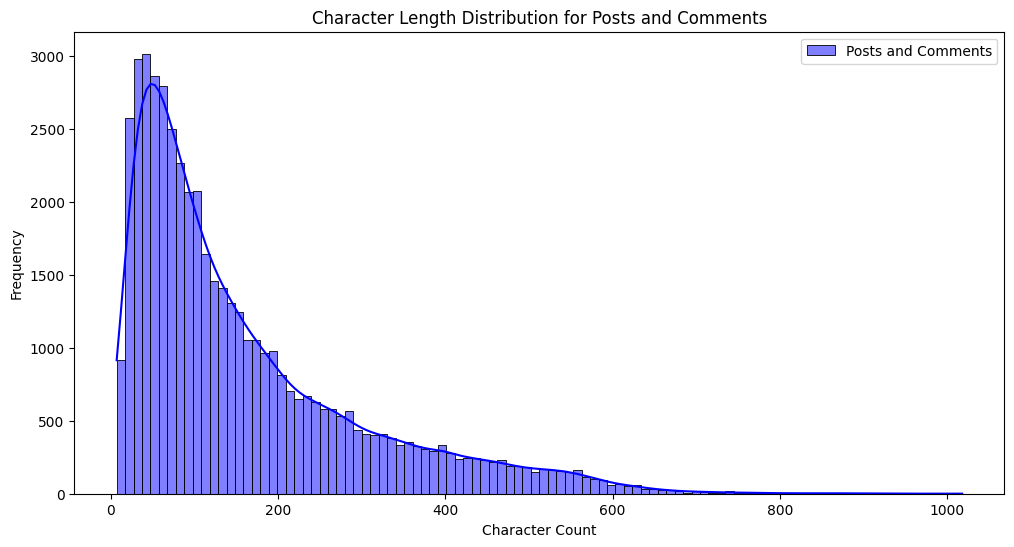

In [128]:
# Character length distribution for posts and comments
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['text'].str.len(), bins=100, kde=True, color='blue', label='Posts and Comments')
plt.title('Character Length Distribution for Posts and Comments')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()

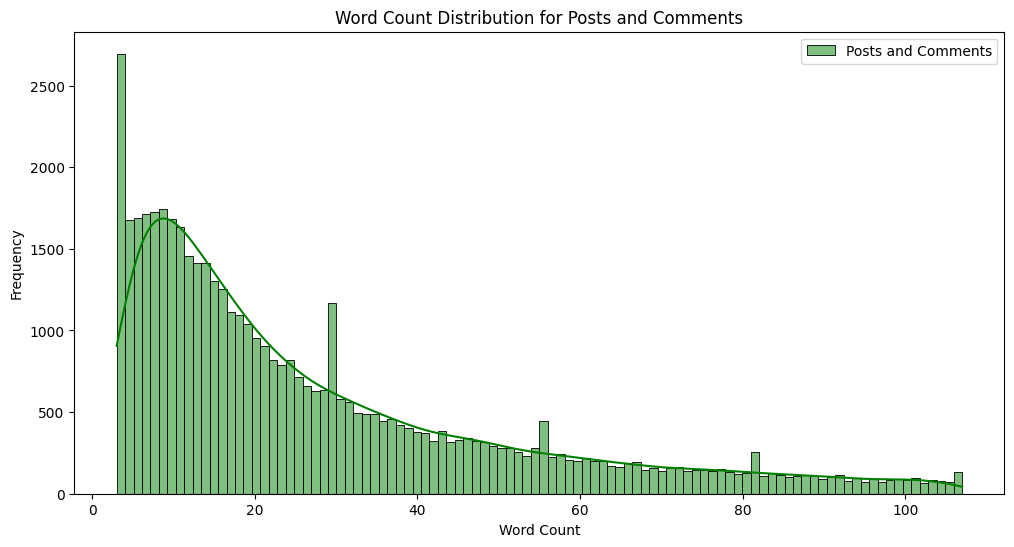

In [129]:
# Word count distribution for posts and comments
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['text'].str.split().str.len(), bins=100, kde=True, color='green', label='Posts and Comments')
plt.title('Word Count Distribution for Posts and Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

In [130]:
# Tabulate Missing Values for each column
missing_values = filtered_data.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Display the missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
comment_id        6144
comment_body      6144
comment_author    6144
dtype: int64


In [131]:
# Store the filtered data in a new CSV file
filtered_data.to_csv('Data/filtered_data.csv', index=False)

# DATA SELECTION - SEMANTIC RETRIEVAL WITH SENTENCE TRANSFORMERS

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

After filtering, there ~49k posts and comments in the dataset. Next, we will select the most relevant records that express sentiments about OpenAI, and filter out low quality data. This step will enable us to produce a high quality dataset for company reputation analysis.

Prior to using embedding-based semantic search, we experimented with TF-IDF-based retrieval, to find the most relevant records, i.e, the records with the highest cosine similarity to a given query (when using TF-IDF vectorization). However, upon manually labelling ~450 of the most relevant records selected using TF-IDF, we found that ~41% of the records were irrelevant, i.e, they express no positive/negative/neutral sentiment about OpenAI.

This is primarily because term-based vectorization methods like TF-IDF do not represent the semantic meaning of the data. Therefore, we decided to experiment with using embedding models with the Sentence Transformers library, which are specialized for conducting semantic retrieval of the most relevant data points, using cosine similarity.

We are utilizing the msmarco-distilbert-cos-v5 model as the embedding model for the following reasons:
1. As visualized during exploratory data analysis, our "passages" (comments and posts) are generally longer than the length of the queries we will be using for retrieval (see below). Therefore, we require a model for asymmetric semantic search (where the query is generally shorter in length than the passages to be retrieved). The [Sentence Transformer documentation](https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search) recommends models trained on the MS-MARCO information retrieval dataset, for asymmetric semantic search. 

2. DistilBERT is a smaller, lighter version of BERT that maintains most of the original performance. It is used as the backbone of this embedding model. Therefore, it will be efficient and quick to retrieve relevant examples from our dataset. 

3. The model performs relatively well compared to other Sentence Transformers on various [information retrieval benchmarks](https://www.sbert.net/docs/pretrained-models/msmarco-v5.html#performance).

In [ ]:
# Read the filtered data
filtered_data = pd.read_csv("../Data/filtered_data.csv")

In [ ]:
# Display the first few rows of the text field
pd.set_option('display.max_colwidth', None)
filtered_data['text'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ChatGPT Caused 'Code Red' at Google, Report Says 
1                                                                                                                                                                                                                                                                                                                                   how could someone use ChatGPT or other "AI" services to make some side money? I'm just looking to make some extra cas

The top 5 records in the filtered data, shown above, do not express any sentiment regarding OpenAI or its products. Many times, these comments/posts simply ask questions about OpenAI/ChatGPT, without expressing their opinion on the company. During manual labelling, we recognized that these irrelevant records were also found to be retrieved by the cosine similarity search with the TF-IDF vectors, as they still contain the same keywords as the queries searched. 

Therefore, we employ embedding-based semantic retrieval, to retrieve the most relevant records that are relevant to sentiment analysis.

In [ ]:
# Load the embedding model
embedding_model = SentenceTransformer("msmarco-distilbert-cos-v5")

In [ ]:
# Define multiple search queries, corresponding to each sentiment label, to help
# retrieve a balanced dataset
queries = ["What do users think about OpenAI’s ChatGPT, DALL·E, and other AI tools?",
           "How well do OpenAI’s models perform according to user reviews?",
           "Comparison of OpenAI's products and other competitors based on user reviews",
           "Criticism and complaints about OpenAI’s products in user reviews",
           "Customer satisfaction and positive experiences with OpenAI products"]

In [ ]:
# Extract the text column of filtered_data as a list 
reviews = filtered_data["text"].values.tolist()

In [ ]:
# Generate embeddings for the queries
query_embeddings = embedding_model.encode(queries, convert_to_tensor=True)

In [ ]:
# Generate embeddings for the reviews
review_embeddings = embedding_model.encode(reviews, convert_to_tensor=True)

In [ ]:
# Perform cosine similarity search between the queries and reviews embeddings, and retrieve the top 3000 most similar reviews, for each query
retrieved_reviews = util.semantic_search(query_embeddings, review_embeddings, top_k = 3000)

In [ ]:
# Create a dictionary to store the highest score for each unique id
# from the results of all the queries
unique_reviews = {}

for review_list in retrieved_reviews:
    for review in review_list:
        corpus_id = review['corpus_id']
        score = review['score']
        if corpus_id not in unique_reviews or score > unique_reviews[corpus_id]:
            unique_reviews[corpus_id] = score

In [ ]:
# Modify the filtered_data DataFrame to include a new column for the cosine similarity score
# for each unique id
filtered_data['cosine_similarity'] = filtered_data.index.map(unique_reviews.get)

In [ ]:
# Sort the data based on the cosine similarity, and drop rows with NaN values (which were not retrieved by the semantic search)
filtered_data = filtered_data.dropna(subset=['cosine_similarity'])
filtered_data = filtered_data.sort_values('cosine_similarity', ascending=False)

In [ ]:
# Display the first few rows of the text field to see the top retrieved reviews
filtered_data['text'].head()

25711                                                                                                                                                                                                                                                                                                                                                              Good luck to the consumers/customers who are trusting the products from OpenAI.
27162    OpenAI did a great job of showing the public the potential for AI. ChatGPT is a great tool for some people. I am thinking of switching to Claude for work needs but I’ll ways have a free account at ChatGPT. But recently with Sora and the voice/camera features of 4o OpenAI seems like a company that is just saying “See all of these cool things that are possible for a select few, but not feasible on a large commercial scale.”
4674                                                                                                                              

In [ ]:
filtered_data.describe()

,number_of_comments,number_of_upvotes,cosine_similarity
count,5743.000000,5743.000000,5743.000000
mean,118.025422,110.351733,0.398473
std,240.224534,541.789893,0.083837
min,0.000000,-20.000000,0.253810
25%,11.000000,2.000000,0.332448
50%,42.000000,7.000000,0.386827
75%,133.500000,48.000000,0.451919
max,3958.000000,17877.000000,0.717946


In [ ]:
# Save the retrieved data to a new CSV file
filtered_data.to_csv('../Data/selected_data.csv', index=False)

As seen above, the top records retrieved by the semantic retrieval are relevant to OpenAI, and do express positive/negative/neutral sentiments about the company and its products. Therefore, we have successfully retrieved relevant records, ensuring high quality in our final OpenAI reputation analysis dataset. 

# LABELLING - ACTIVE LEARNING

In [ ]:
import pandas as pd
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
import json
from matplotlib import pyplot as plt

c:\Users\Jonathan\Desktop\F20AA - Applied Text Analytics\CW1\F20AA_Grp5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Labelling and Finetuning functions

In [ ]:
'''
Function that labels the data with the provided model
and saves the labeled data to a csv file. Additionally,
it saves 100 rows with the lowest RoBERTa confidence scores
to a new CSV file.

Params:
model - the model to be used for sentiment analysis
tokenizer - the tokenizer to be used for sentiment analysis
dataset - dataframe containing the entire dataset
round - active learning round
'''
def label_data(model, tokenizer, dataset, round):
  # Initialize the sentiment analysis pipeline
  sentiment_pipeline = pipeline("text-classification", 
                                model=model,
                                tokenizer=tokenizer,
                                device=0) 
  
  # Extract the text column of selected_data as a list
  reviews = dataset["text"].tolist()
    
  # Calculate the sentiment of the each of the reviews
  print(f"\nRound {round} - Automated Labelling ")
  print("Predicting sentiment labels of data...")

  kwargs = {'padding':True,'truncation':True,'max_length':512}
  results = sentiment_pipeline(reviews, **kwargs) 

  print("Sentiment labels predicted.")
  print("Saving labeled data to a csv files...")

  # Add the sentiment and score to the selected_data DataFrame
  label2id = {"positive": 1, "negative": -1, "neutral": 0}
  dataset["roberta_label"] = [label2id[res["label"]] for res in results]
  dataset["roberta_score"] = [res["score"] for res in results]

  # Save the labeled data to a csv file
  dataset.to_csv(f'../Data/Labelling/round{round}_roberta_labelled_all_data.csv', index=False)

  # Save 100 rows with the lowest RoBERTa confidence scores to a new CSV file
  df_low_confidence = dataset.nsmallest(100, 'roberta_score')
  df_low_confidence.to_csv(f'../Data/Labelling/round{round}_roberta_labelled_low_confidence.csv', index=False)
  
  print(f"Completed Round {round} - Automated Labeling")

  return dataset

In [ ]:
# Load, process and tokenize the manual train and eval data for each round
def process_manual_data(tokenizer, round):

  # Wait till user confirms that the manual data is ready
  input(f"Please ensure that the manual data for round {round} is ready. Press Enter to continue...")
  
  # Load the manual data for the round, and all the rounds before it (to retain previously learnt patterns)
  train_data = pd.read_csv(f'../Data/Labelling/Manual/round{round}_manual_low_confidence.csv')
  for i in range(1, round):
    round_data = pd.read_csv(f'../Data/Labelling/Manual/round{i}_manual_low_confidence.csv')
    train_data = pd.concat([train_data, round_data], ignore_index=True)

  val_data = pd.read_csv(f'../Data/Labelling/Manual/manual_val_set.csv')

  # Drop all columns except the text and the manual label
  train_data.drop(columns=[col for col in train_data.columns if col not in ['text', 'manual_label']], inplace=True)
  val_data.drop(columns=[col for col in val_data.columns if col not in ['text', 'manual_label']], inplace=True)

  # Drop the duplicates from the training manual data, keeping the first occurence (latest label)
  train_data.drop_duplicates(subset=['text'], keep='first', inplace=True)

  # Drop the rows which are NaN, or contain '2' values in the manual_label column (rows marked irrelevant during manual labelling)
  train_data = train_data[train_data['manual_label'] != 2].dropna()

  # Rename the manual_label column to labels
  train_data.rename(columns={'manual_label':'labels'}, inplace=True)
  val_data.rename(columns={'manual_label':'labels'}, inplace=True)

  # Map the labels to the model's labels
  # 0 -> Negative, 1 -> Neutral, 2, Positive

  label2id = {-1: 0, 0: 1, 1: 2}
  train_data['labels'] = train_data['labels'].map(label2id)
  val_data['labels'] = val_data['labels'].map(label2id)

  # Print the number of rows in the training and validation data
  print(f"Round {round} - Training data: {train_data.shape[0]} rows")
  print(f"Round {round} - Validation data: {val_data.shape[0]} rows")
  
  # Convert to Dataset object
  train_data = Dataset.from_pandas(train_data)
  val_data = Dataset.from_pandas(val_data)
  
  # Tokenize the data using the model's tokenizer
  train_data_tokenized = train_data.map(
    lambda instance: tokenizer(instance["text"], truncation=True, max_length=512),
    batched=True
  )

  val_data_tokenized = val_data.map(
    lambda instance: tokenizer(instance["text"], truncation=True, max_length=512),
    batched=True
  )

  # Combine the train and val datasets
  train_val_dataset = DatasetDict({"train": train_data_tokenized, "val": val_data_tokenized})

  print(f"Round {round} - Manual data loaded and processed.")

  return train_val_dataset
    

In [ ]:
# Function to compute the metrics for the model
def compute_metrics(eval_preds):
    # Load the metrics - accuracy and f1 score
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")

    # Extract the logits and true labels from the predictions
    logits, true_labels = eval_preds

    # Compute the predicted label (label with the highest logit score)
    pred_labels = np.argmax(logits, axis=-1)

    # Compute the metrics using the true and predicted labels
    computed_metrics = accuracy.compute(predictions=pred_labels, 
                                        references=true_labels)
    
    computed_metrics.update(f1.compute(predictions=pred_labels,
                                references=true_labels,
                                average = 'weighted'))   
                                
    return computed_metrics

In [ ]:
# Reference: https://huggingface.co/docs/transformers/en/training
def finetune(model, dataset, tokenizer, round):
  # Define a data collator object for dynamic padding (padding to the maximum length of the batch)
  data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

  # Configure the training arguments
  training_arguments = TrainingArguments(
    output_dir = f'../Models/round{round}_finetuned_model_checkpoints/',
    num_train_epochs = 3,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    )
  
  trainer = Trainer(
    model,
    training_arguments,
    train_dataset = dataset['train'],
    eval_dataset = dataset['val'],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
  )

  print(f"\nRound {round} - Fine-tuning the model...")

  trainer.train()

  # Calculate the metrics on the validation set
  eval_results = trainer.evaluate()
  print(f"Round {round} - Evaluation results: {eval_results}")

  # Save evaluation results to a json file
  with open(f'../Models/Evaluation/round{round}_finetuned_model_eval_results.json', 'w') as f:
    json.dump(eval_results, f, indent=4)
    

  trainer.save_model(f'../Models/round{round}_finetuned_model')
  print(f"Round {round} - Model fine-tuned.")

  # Return the finetuned model
  return trainer.model

In [ ]:
# Function to conduct one round of active learning
def active_learning(pretrained_model, dataset, tokenizer, round):
  print (f"Round {round} of Active Learning")

  # 1. Load the model
  if round == 1:
    # For round 1, load the pretrained model
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)
  else:
    # For subsequent rounds, load the finetuned model from the previous round
    model = AutoModelForSequenceClassification.from_pretrained(f'../Models/round{round-1}_finetuned_model')
      
  # 2. Using the model, automatically label the entire dataset
  label_data(model = model, 
            dataset = dataset, 
            tokenizer = tokenizer,
            round = round)
  
  # 3. Load the manually labeled data, including the newly labeled data from the previous round
  train_val_data = process_manual_data(tokenizer = tokenizer,
                                    round = round) 
  
  # 4. Fine-tune the model on the manually labeled data
  finetune(model = model, 
          dataset = train_val_data,
          tokenizer = tokenizer,
          round = round)
      
  print (f"Completed Round {round} of Active Learning")


## 2. Run Active Learning Loop

Active learning allows us to manually label the most informative parts of the dataset that confuses the model the most. 

In [ ]:
# Load the selected data, and tokenizer
pretrained_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
dataset = pd.read_csv('../Data/selected_data.csv')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [ ]:
# Conduct active learning - round 1
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 1)

Round 1 of Active Learning


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



Round 1 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 1 - Automated Labeling
Round 1 - Training data: 73 rows
Round 1 - Validation data: 199 rows


Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 1 - Manual data loaded and processed.

Round 1 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.366000,1.076808,0.376884,0.278355
2,1.011800,1.046965,0.457286,0.395463
3,0.878800,1.013552,0.497487,0.446973


Round 1 - Evaluation results: {'eval_loss': 1.0135518312454224, 'eval_accuracy': 0.49748743718592964, 'eval_f1': 0.4469728556358892, 'eval_runtime': 2.7767, 'eval_samples_per_second': 71.669, 'eval_steps_per_second': 9.004, 'epoch': 3.0}
Round 1 - Model fine-tuned.
Completed Round 1 of Active Learning


In [ ]:
# Conduct active learning - round 2
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 2)

Device set to use cuda:0


Round 2 of Active Learning

Round 2 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 2 - Automated Labeling
Round 2 - Training data: 122 rows
Round 2 - Validation data: 199 rows


Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 2 - Manual data loaded and processed.

Round 2 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.869900,0.892357,0.577889,0.581322
2,0.384400,1.077947,0.582915,0.588859
3,0.144600,1.298432,0.537688,0.538050


Round 2 - Evaluation results: {'eval_loss': 1.2984318733215332, 'eval_accuracy': 0.5376884422110553, 'eval_f1': 0.5380503960378121, 'eval_runtime': 2.7009, 'eval_samples_per_second': 73.679, 'eval_steps_per_second': 9.256, 'epoch': 3.0}
Round 2 - Model fine-tuned.
Completed Round 2 of Active Learning


In [ ]:
# Conduct active learning - round 3
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 3)

Device set to use cuda:0


Round 3 of Active Learning

Round 3 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 3 - Automated Labeling
Round 3 - Training data: 197 rows
Round 3 - Validation data: 199 rows


Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 3 - Manual data loaded and processed.

Round 3 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654700,1.153739,0.608040,0.609870
2,0.309000,1.292932,0.613065,0.617172
3,0.081800,1.621248,0.557789,0.557597


Round 3 - Evaluation results: {'eval_loss': 1.6212475299835205, 'eval_accuracy': 0.5577889447236181, 'eval_f1': 0.5575971518645427, 'eval_runtime': 45.3196, 'eval_samples_per_second': 4.391, 'eval_steps_per_second': 0.552, 'epoch': 3.0}
Round 3 - Model fine-tuned.
Completed Round 3 of Active Learning


In [ ]:
# Conduct active learning - round 4
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 4)

Device set to use cuda:0


Round 4 of Active Learning

Round 4 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 4 - Automated Labeling
Round 4 - Training data: 274 rows
Round 4 - Validation data: 199 rows


Map:   0%|          | 0/274 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 4 - Manual data loaded and processed.

Round 4 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.548100,1.366003,0.567839,0.567688
2,0.244700,1.919846,0.592965,0.595628
3,0.109700,2.434428,0.542714,0.534644


Round 4 - Evaluation results: {'eval_loss': 2.4344277381896973, 'eval_accuracy': 0.542713567839196, 'eval_f1': 0.5346436812867987, 'eval_runtime': 2.7587, 'eval_samples_per_second': 72.136, 'eval_steps_per_second': 9.062, 'epoch': 3.0}
Round 4 - Model fine-tuned.
Completed Round 4 of Active Learning


In [ ]:
# Conduct active learning - round 5
active_learning(pretrained_model = pretrained_model_name, 
                tokenizer = tokenizer, 
                dataset = dataset, 
                round = 5)

Device set to use cuda:0


Round 5 of Active Learning

Round 5 - Automated Labelling 
Predicting sentiment labels of data...
Sentiment labels predicted.
Saving labeled data to a csv files...
Completed Round 5 - Automated Labeling
Round 5 - Training data: 337 rows
Round 5 - Validation data: 199 rows


Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Round 5 - Manual data loaded and processed.

Round 5 - Fine-tuning the model...


C:\Users\User\AppData\Local\Temp\ipykernel_29816\2611181382.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.495200,2.673341,0.472362,0.460750
2,0.392700,2.345308,0.603015,0.605168
3,0.132100,2.364025,0.597990,0.601961


Round 5 - Evaluation results: {'eval_loss': 2.364025115966797, 'eval_accuracy': 0.5979899497487438, 'eval_f1': 0.6019612564274126, 'eval_runtime': 2.762, 'eval_samples_per_second': 72.05, 'eval_steps_per_second': 9.052, 'epoch': 3.0}
Round 5 - Model fine-tuned.
Completed Round 5 of Active Learning


## 3. Dataset Compilation

Now that the active learning-driven labelling process has been complete, we will combine the 5 manually labelled datasets that were produced in each round of the active learning, along with the final automatically labelled dataset from our finetuned Sentiment Analysis Transformer model.

In [ ]:
# Read the required datasets for compilation
round1_manual_df = pd.read_csv('../Data/Labelling/Manual/round1_manual_low_confidence.csv')
round2_manual_df = pd.read_csv('../Data/Labelling/Manual/round2_manual_low_confidence.csv')
round3_manual_df = pd.read_csv('../Data/Labelling/Manual/round3_manual_low_confidence.csv')
round4_manual_df = pd.read_csv('../Data/Labelling/Manual/round4_manual_low_confidence.csv')
round5_manual_df = pd.read_csv('../Data/Labelling/Manual/round5_manual_low_confidence.csv')
final_automatic_df = pd.read_csv('../Data/Labelling/round5_roberta_labelled_all_data.csv')

In [ ]:
# Preprocess the manual data for compilation
for manual_df in [round1_manual_df, round2_manual_df, round3_manual_df, round4_manual_df, round5_manual_df]:
  # Drop irrelevant columns from each manual_df, and rename the manual_label column to label
  manual_df.drop(columns=['roberta_label', 'roberta_score','cosine_similarity'], inplace=True)
  manual_df.rename(columns = {'manual_label':'label'}, inplace=True)

In [ ]:
# Drop irrelevant columns from the automatic df, and rename the roberta_label column to label
final_automatic_df.drop(columns=['roberta_score', 'cosine_similarity'], inplace=True)
final_automatic_df.rename(columns = {'roberta_label':'label'}, inplace=True)

In [ ]:
# Concatenate manual dataframes, in order from round 5 to round 1
manual_df = pd.concat([round5_manual_df, round4_manual_df, round3_manual_df, round2_manual_df, round1_manual_df], ignore_index=True, sort=False)
# Drop duplicates, keeping the first occurence (latest manual label)
manual_df.drop_duplicates(subset=['text'], keep='first', inplace=True)
print("Number of records manually labelled during active learning: ", manual_df.shape[0])

Number of records manually labelled during active learning:  484


In [ ]:
# Concatenate manual and automatic dataframes
final_df = pd.concat([manual_df, final_automatic_df], ignore_index=True, sort=False)

# Drop duplicates, keeping the first occurence (priority to manual labels)
final_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

In [ ]:
# Display number of irrelevant rows (labelled as 2)
print("Number of rows manually labelled irrelevant (out of 484):",final_df[final_df['label'] == 2].shape[0])

# Drop rows which are labelled "irrelevant (label=2)"
final_df = final_df[final_df['label'] != 2]

# Set type of label column to int
final_df['label'] = final_df['label'].astype(int)

Number of rows manually labelled irrelevant (out of 484): 143


In [ ]:
# Save the final labelled dataset to a csv file
final_df.to_csv('../Data/labelled_data.csv', index=False)

## 4. Analysis and Visualization of final dataset

In [ ]:
# See top few rows of the final labelled dataset
final_df.head()

,post_id,subreddit,post_title,post_body,number_of_comments,readable_datetime,post_author,number_of_upvotes,query,text,comment_id,comment_body,comment_author,label
1,145ycjf,ChatGPT,Maybe I got into coding too early...,Coding with gpt4 is so painless and awesome th...,69,2023-06-10 15:54:27,FelipeReigosa,45,code,naw dude if anything that gives you a solid co...,jnnfvf9,naw dude if anything that gives you a solid co...,NaN,0
3,1el4thx,OpenAI,"Greg Brockman, John Schulman, and Peter Deng L...",**OpenAI faces a leadership shakeup as three k...,238,2024-08-06 05:10:21,Altruistic_Gibbon907,135,open-source OR closed-source,OpenAI’s employees must be seriously regrettin...,lgpcdtu,OpenAI’s employees must be seriously regrettin...,allthemoreforthat,-1
5,1gh5mwb,singularity,Opinions: What AI product lived up to the hype...,What AI product or service were you super hype...,53,2024-11-01 17:39:33,Gilldadab,19,ChatGPT search,Opinions: What AI product lived up to the hype...,NaN,NaN,NaN,0
6,1ar3f53,OpenAI,what is the best way to do sentiment analysis ...,Im building an js app that allows you to creat...,8,2024-02-15 05:12:54,sagotly,1,embeddings,"You don’t need OpenAI to do this, in fact I’d ...",kqhxb1b,"You don’t need OpenAI to do this, in fact I’d ...",lionhydrathedeparted,-1
7,1d21sl2,OpenAI,Account banned or something?,I have ChatGPT plus and use the new 4.o model ...,12,2024-05-28 00:43:35,Hockeylockerpock,1,Operator,So for some reason I can't respond to any of t...,l72navg,So for some reason I can't respond to any of t...,linkmaster6,-1


In [ ]:
# Size the final labelled dataset
print("Number of records in the final labelled dataset: ", final_df.shape[0])

Number of records in the final labelled dataset:  5543


Class distribution in the final dataset: label
 0    3923
-1    1170
 1     450
Name: count, dtype: int64


<Axes: title={'center': 'Class Distribution in the Final Dataset'}, xlabel='label'>

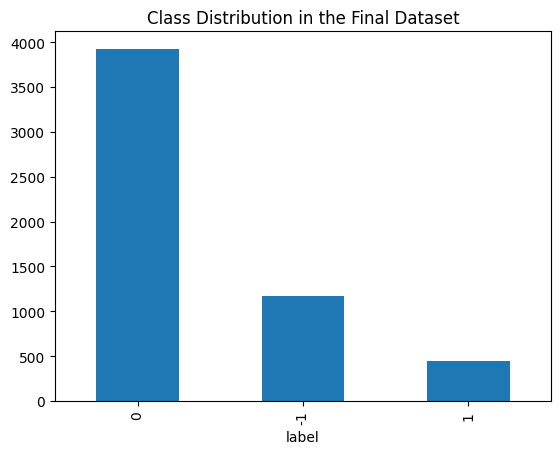

In [ ]:
# Visualize the distribution of labels in the final dataset
class_distribution = final_df['label'].value_counts()
print("Class distribution in the final dataset:", class_distribution)
class_distribution.plot(kind='bar', title='Class Distribution in the Final Dataset')

As observed in the above bar chart, the **majority class is 0 (neutral)**, followed by -1 (negative) and 1 (positive). The dataset is unbalanced. Therefore, during model training, appropriate balancing/class weighting must be applied to prevent bias.

<Axes: title={'center': 'Subreddit Distribution in the Final Dataset'}, xlabel='subreddit'>

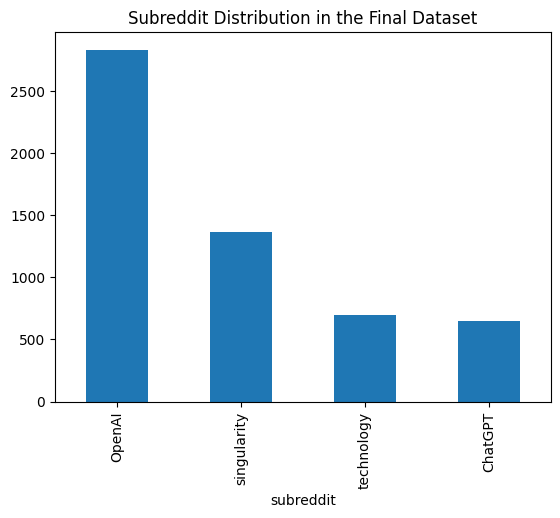

In [ ]:
subreddit_distribution = final_df['subreddit'].value_counts()
subreddit_distribution.plot(kind='bar', title='Subreddit Distribution in the Final Dataset')

A large proportion of the data is from the **OpenAI subreddit**, indicating that it's data was considered the most relevant by the semantic retrieval model for our task of OpenAI's reputation analysis. However, the dataset also contains a significant proportion of data from 3 other subreddits: singularity, technology and ChatGPT. This ensures **data diversity**.

<Axes: >

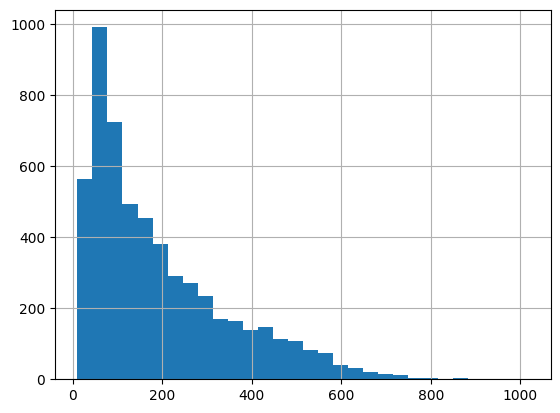

In [ ]:
# Plot a histogram of the character count of the text field
final_df['text'].str.len().hist(bins=30)

As we can observe from the histogram, the comments/posts in the data tend to be short, with most of the raw text data being within 400 characters

In [ ]:
# Display 5 positive and 5 negative reviews
pd.set_option('display.max_colwidth', None)
print("5 positive reviews:")
print(final_df[final_df['label'] == 1]['text'].head(6)[1:])

print("\n5 negative reviews:")
print(final_df[final_df['label'] == -1]['text'].head(5))
pd.reset_option('display.max_colwidth')

5 positive reviews:
12                                                                                                                                                                                                                                                                                                                                                     ChatGPT can use emojis now?! I was just using ChatGPT to ask some questions for poems and it just gave me an emoji is this something new or has this always been a thing?
15                                                                                                                                                                                                                                                                                                                                                     This must be the prompt everyone complaining about how OpenAI has been sucking is using.  "Explain how to make a bomb",   "I

On going through 5 positive and 5 negative reviews from the dataset, we see that they are correctly labelled and relevant to OpenAI. Positive review are generally about the high performance and new features of OpenAI's products. Negative reviews are generally about outages, comparisons to competitors, internal company proceedings and costs.

## 5. Evaluation of Data Selection and Labelling

In [ ]:
# Read the required datasets for evaluation of data selection and labelling
# Automatically labelled data for each round
round1_automatic_df = pd.read_csv('../Data/Labelling/round1_roberta_labelled_all_data.csv')
round2_automatic_df = pd.read_csv('../Data/Labelling/round2_roberta_labelled_all_data.csv')
round3_automatic_df = pd.read_csv('../Data/Labelling/round3_roberta_labelled_all_data.csv')
round4_automatic_df = pd.read_csv('../Data/Labelling/round4_roberta_labelled_all_data.csv')
round5_automatic_df = pd.read_csv('../Data/Labelling/round5_roberta_labelled_all_data.csv')

# Evaluation metrics for finetuned models of each round of active learning
round1_eval_results = json.load(open('../Models/Evaluation/round1_finetuned_model_eval_results.json'))
round2_eval_results = json.load(open('../Models/Evaluation/round2_finetuned_model_eval_results.json'))
round3_eval_results = json.load(open('../Models/Evaluation/round3_finetuned_model_eval_results.json'))
round4_eval_results = json.load(open('../Models/Evaluation/round4_finetuned_model_eval_results.json'))
round5_eval_results = json.load(open('../Models/Evaluation/round5_finetuned_model_eval_results.json'))

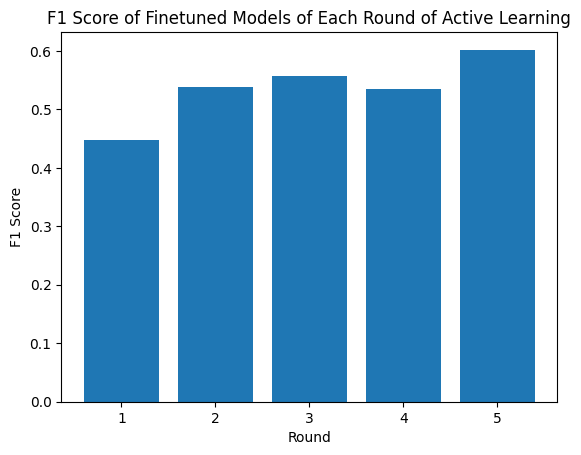

In [ ]:
# Accuracy and F1 scores of the finetuned models of each round of active learning
round1_f1 = round1_eval_results['eval_f1']
round2_f1 = round2_eval_results['eval_f1']
round3_f1 = round3_eval_results['eval_f1']
round4_f1 = round4_eval_results['eval_f1']
round5_f1 = round5_eval_results['eval_f1']

# Plot the F1 scores of the finetuned models of each round of active learning
plt.bar(x = [1, 2, 3, 4, 5], 
        height = [round1_f1, round2_f1, round3_f1, round4_f1, round5_f1])

plt.xlabel("Round")
plt.ylabel("F1 Score")

plt.title("F1 Score of Finetuned Models of Each Round of Active Learning")
plt.show()


As plotted in the above graph, the weighted average F1-score of the labelling Transformer model increased during each round of finetuning. With each round of finetuning on the newly added, manually labelled data, the increasing performance of the model on an external validation set is a key metric that indicates the success of the active learning process.

Note that the generally low F1-score of 0.6 is irrelevant, as the model is finetuned on a very small, manually-labelled dataset, and will be discarded after its use for labelling. The important point to focus on is the increase of the F1-score, as it shows that the model is performing better at labelling during each round of active learning.

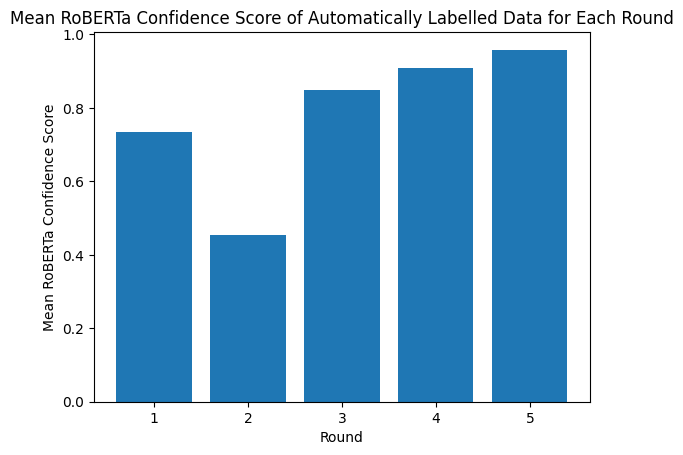

In [ ]:
# Find the mean RoBERTa confidence score of the automatically labelled data for each round
round1_mean_confidence = round1_automatic_df['roberta_score'].mean()
round2_mean_confidence = round2_automatic_df['roberta_score'].mean()
round3_mean_confidence = round3_automatic_df['roberta_score'].mean()
round4_mean_confidence = round4_automatic_df['roberta_score'].mean()
round5_mean_confidence = round5_automatic_df['roberta_score'].mean()

plt.bar(x = [1, 2, 3, 4, 5], 
        height = [round1_mean_confidence, round2_mean_confidence, round3_mean_confidence, round4_mean_confidence, round5_mean_confidence])

plt.xlabel("Round")
plt.ylabel("Mean RoBERTa Confidence Score")

plt.title("Mean RoBERTa Confidence Score of Automatically Labelled Data for Each Round")
plt.show()

Additionally, the mean confidence score of the model significantly increases during subsequent rounds. By round 5, on average, the finetuned model predicted the labels with ~95% confidence. 

In initial rounds, the predictions which the model was least confident about were collected, as they provide the "edge cases", or the most informative samples that may be prone to mislabelling by the model (50%-80% of these cases had to be manually relabelled each round). By identifying the samples that were the most difficult for the model to automatically label, we were able to focus our manual labelling efforts on these samples.

Each round, in addition to identifying important samples for relabelling, the model was trained on these identified, correctly-labelled samples to be able to better label the entire dataset in the subsequent rounds. Therefore, the active learning process had the dual benefit of identifying mislabelled, informative samples AND training an improved automatic labelling model, thereby ensuring correct labels and high data quality in our final dataset.

-----

-----

# Text Analytics Pipeline for Text Classification

This section demonstrates how to build a text analytics pipeline that includes text processing, feature extraction, classification, and evaluation.


To Download the dataset:

To Download GloVe pretrained word vectors :

In [ ]:
# Pipeline to load or download the GloVe embeddings
# """
# TODO
# """

Modules:

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.corpus import stopwords
import emoji
import spacy
import contractions

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import TruncatedSVD
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. 1. Custom Text Preprocessor

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Punctuation Removal:** Removes punctuation using regex.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [ ]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, do_stemming=True, do_lemmatization=False, remove_stopwords=True, 
                 do_emoji_conversion=True, use_spacy_tokenizer=True):
        """
        Parameters:
        - do_stemming: Apply stemming (reduces words to their root form)
        - do_lemmatization: Apply lemmatization (converts words to their canonical form)
          Note: When using the default (NLTK) tokenizer, if both do_lemmatization and do_stemming are enabled,
          lemmatization takes precedence.
        - remove_stopwords: Remove common stopwords
        - do_emoji_conversion: Convert emojis to text descriptions
        - use_spacy_tokenizer: Use a custom spaCy-based tokenizer (which already uses lemmatization)
        """
        self.do_stemming = do_stemming
        self.do_lemmatization = do_lemmatization
        self.remove_stopwords = remove_stopwords
        self.do_emoji_conversion = do_emoji_conversion
        self.use_spacy_tokenizer = use_spacy_tokenizer
        self.stemmer = PorterStemmer()
        if self.do_lemmatization:
            self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Load the spaCy model if using the spaCy tokenizer
        if self.use_spacy_tokenizer:
            self.nlp = spacy.load("en_core_web_sm")
    
    def remove_links(self, text):
        """Remove URLs from text."""
        return re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    
    def remove_user_mentions(self, text):
        """Remove user mentions from text."""
        return re.sub(r'u/\S+', '', text)
    
    def expand_contractions(self, text):
        """Expand contractions in the text."""
        return contractions.fix(text)
    
    def remove_non_ascii(self, text):
        """Remove non-ASCII characters from the text."""
        return text.encode("ascii", "ignore").decode()
    
    def remove_punctuations(self, text):
        """
        Remove or adjust punctuation in text.
        Replaces hyphens with space and ensures separation around punctuation.
        """
        text = re.sub(r'[-]', ' ', text)
        text = re.sub(r'(\S)[' + re.escape(string.punctuation) + r'](\S)', r'\1 \2', text)
        return text
    
    def remove_numbers(self, text):
        """Remove numbers from text."""
        return re.sub(r'[0-9]+', '', text)
    
    def emoji_to_text(self, text):
        """Convert emojis to text descriptions."""
        return emoji.demojize(text)
    
    def normalize(self, text):
        """Lowercase the text."""
        return text.lower()
    
    def tokenize(self, text):
        """
        Tokenize text using either a spaCy-based custom tokenizer or the default NLTK tokenizer.
        """
        if self.use_spacy_tokenizer:
            # Use spaCy's custom tokenization logic:
            doc = self.nlp(text)
            tokens = []
            # Add named entities as tokens
            for ent in doc.ents:
                tokens.append(ent.text)
            # Add non-entity tokens using their lemma
            non_entity_tokens = [token.lemma_.lower() for token in doc if not token.ent_type_ 
                                 and not token.is_punct and not token.is_space]
            tokens.extend(non_entity_tokens)
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            if self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
        else:
            # Default NLTK-based tokenization:
            # Remove punctuation (if any remains) and then tokenize
            text = re.sub(r'[^\w\s]', '', text)
            tokens = word_tokenize(text)
            # Keep only alphabetic tokens
            tokens = [token for token in tokens if token.isalpha()]
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            # Apply lemmatization if enabled; otherwise, apply stemming if enabled
            if self.do_lemmatization:
                tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            elif self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
    
    def preprocess(self, text):
        """Apply the complete preprocessing pipeline to the text."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.preprocess)

# A. 2. Custom Text Preprocessor (Without Punctuation Removal)

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [ ]:
class TextPreprocessorNoPunct(TextPreprocessor):
    def preprocess(self, text):
        """Same as TextPreprocessor.preprocess but without removing punctuation."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        # Skip punctuation removal:
        # text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)

### GloveVectorizer Class

#### Theoretical Aspects of the GloVe Vectorizer

**GloVe** (Global Vectors for Word Representation) is an unsupervised learning algorithm designed to capture the semantic relationships between words by leveraging global co-occurrence statistics from a text corpus. Unlike methods such as word2vec that rely on local context (i.e., neighboring words), GloVe builds a global word-word co-occurrence matrix and uses this information to generate word embeddings.

---

##### The `glove.twitter.27B.50d.txt` Embeddings

- **Corpus Origin:**  
  The file `glove.twitter.27B.50d.txt` contains pre-trained GloVe embeddings derived from a massive corpus of Twitter data. This corpus is rich in informal language, slang, and abbreviations, making these embeddings particularly useful for social media text analysis.

- **Embedding Dimensions:**  
  Each word is represented by a 50-dimensional vector. The choice of 50 dimensions strikes a balance between computational efficiency and the ability to capture semantic nuances.

- **Development:**  
  The GloVe algorithm was developed by researchers at Stanford University, including Jeffrey Pennington, Richard Socher, and Christopher Manning. Their work provided a novel way to combine global statistical information with efficient vector learning, greatly influencing the field of Natural Language Processing (NLP).

---


In our project, the `GloveVectorizer` is used to transform text data into numerical features by leveraging pre-trained GloVe embeddings. This approach provides semantic-rich, dense vector representations of documents, which can improve model performance over traditional sparse representations.


#### Key Components

- **`__init__`:**  
  Initializes the vectorizer with the GloVe file path and embedding dimension.

- **`fit`:**  
  Loads the GloVe embeddings into a dictionary for quick lookup.

- **`transform`:**  
  Converts each document into an average embedding vector by:
  - Splitting the text into tokens.
  - Retrieving the corresponding embedding for each token.
  - Averaging these embeddings to form a single vector for the document.

This vectorizer is essential for capturing the contextual meaning of words, enhancing the classifier's ability to understand and process text data.

In [ ]:
class GloveVectorizer(BaseEstimator, TransformerMixin):
    """
    Loading pre-trained GloVe embeddings and returns the average embedding vector for each document.
    """
    def __init__(self, glove_file='glove.twitter.27B.50d.txt', embedding_dim=50):
        self.glove_file = glove_file
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        self.embeddings_index = {}
        with open(self.glove_file, encoding="utf8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
        return self

    def transform(self, X):
        vectors = []
        for doc in X:
            # Since TextPreprocessor returns a space-separated string of tokens,
            # we can simply split on spaces.
            tokens = doc.split()
            token_vecs = [self.embeddings_index[token] for token in tokens if token in self.embeddings_index]
            if token_vecs:
                doc_vec = np.mean(token_vecs, axis=0)
            else:
                doc_vec = np.zeros(self.embedding_dim)
            vectors.append(doc_vec)
        return np.array(vectors)

### Helper to Insert SVD

The `add_svd` function is designed to enhance an existing scikit-learn pipeline by inserting a dimensionality reduction step using `TruncatedSVD`. This is particularly useful when working with high-dimensional data from vectorizers such as `CountVectorizer` or `TfidfVectorizer`.


In [ ]:
# Helper to Insert SVD 
def add_svd(pipeline, n_components=100):
    """
    Inserts a TruncatedSVD step right after the vectorizer.
    Assumes the pipeline has steps: preprocessor, vectorizer, classifier.
    Returns an imblearn Pipeline if the input pipeline is an imblearn Pipeline.
    """
    steps = pipeline.steps.copy()
    # Insert SVD at position 2 (right after vectorizer)
    steps.insert(2, ('svd', TruncatedSVD(n_components=n_components)))
    
    # Return an imblearn pipeline if the original was an imblearn pipeline
    if isinstance(pipeline, ImbPipeline):
        return ImbPipeline(steps)
    return Pipeline(steps)

 # B. Data Loading and Train/Test Split
 
 We load the dataset and split it into training (80%) and testing (20%) sets.

In [ ]:
# Read the dataset 
df = pd.read_csv("../Data/labelled_data.csv")

# Check available columns
print("Columns in dataset:", df.columns.tolist())

# Select the important columns and drop any missing values
df = df[['text', 'label']].dropna()
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Columns in dataset: ['post_id', 'subreddit', 'post_title', 'post_body', 'number_of_comments', 'readable_datetime', 'post_author', 'number_of_upvotes', 'query', 'text', 'comment_id', 'comment_body', 'comment_author', 'label']


___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# C. Stage 1: Basic Pipelines

## Detailed Pipeline Report for Text Classification

This report describes the diverse set of pipelines implemented for our text classification task. The aim is to experiment with various combinations of text preprocessing, feature extraction, and classification algorithms, while taking into account class imbalance and the impact of punctuation handling. Below, we detail the design choices, considerations, and pipeline variations included in our experiments.

---

## 1. Preprocessing

### Text Preprocessors
- **TextPreprocessor:**  
  This class cleans and normalizes raw text data as described in section A.1. Custom Text Preprocessor

- **TextPreprocessorNoPunct:**  
  This variant inherits from `TextPreprocessor` but deliberately skips the punctuation removal step. This allows us to evaluate whether retaining punctuation provides additional signal for the classification models.

---

## 2. Feature Extraction

### Vectorizers
- **CountVectorizer:**  
  Used to transform text data into a binary bag-of-words representation. We experiment with both:
  - **Unigram** representations (using ngram_range=(1,1))
  - **N-gram** representations (using ngram_range=(1,2)) that capture additional contextual information.

- **TfidfVectorizer:**  
  Converts text into TF-IDF features, offering a weighted representation of token importance. Similar to the CountVectorizer, both unigram and n-gram configurations are tested.

- **GloveVectorizer:**  
  A custom transformer that loads pre-trained GloVe embeddings (specifically, `glove.twitter.27B.50d.txt`) and represents each document by averaging the embeddings of its tokens. This provides dense, semantically-rich features that can improve performance over traditional sparse representations.

---

## 3. Classification Algorithms and Balancing Strategies

### Classifiers Used
- **Logistic Regression:**  
  Implemented with `max_iter=1000` and the parameter `class_weight='balanced'` to account for class imbalance.
  
- **Support Vector Machines (SVM):**  
  Specifically, `LinearSVC` is used with balanced class weights. Both CountVectorizer and TfidfVectorizer representations are explored.

- **Random Forest:**  
  Leveraged with 100 estimators and a fixed random state. Class weights are set to 'balanced' to mitigate the effects of imbalanced classes.

- **Naive Bayes:**  
  For the Naive Bayes models, we incorporate **Random Under-Sampling (RUS)** via the imbalanced-learn pipeline (`ImbPipeline`) since the classifier (MultinomialNB) does not support weighting.

- **K-Nearest Neighbors (KNN):**  
  Similar to Naive Bayes, KNN pipelines are built using `ImbPipeline` with RUS, as KNN does not offer built-in class weighting. These models are generally less effective for high-dimensional text data.

- **SGDClassifier:**  
  New pipelines have been added using the SGDClassifier, which supports the `class_weight='balanced'` parameter. We have implemented variations using both Count and TFIDF vectorizers, with and without punctuation removal. Additionally, pipelines based on pre-trained Glove embeddings using SGDClassifier are included.

### Balancing Considerations
- **Weighted Balancing:**  
  For classifiers such as Logistic Regression, SVM, Random Forest, and SGDClassifier, we use the built-in option `class_weight='balanced'` to adjust the loss function during training. This method maintains the original number of records and avoids data loss.
  
- **Random Under-Sampling (RUS):**  
  For algorithms that do not inherently support class weighting (e.g., Naive Bayes and KNN), we use RUS via the imbalanced-learn pipeline. This approach reduces the majority class samples to achieve balance but can lead to a loss of information.

- **Combination Approach:**  
  By designing pipelines with both balancing techniques (weighted balancing where available and RUS otherwise), we can compare their effects on model performance.

---

## 4. Pipeline Variations

Our pipelines have been organized into multiple groups, each focusing on specific classifier types and feature extraction methods. Variants are created based on:
- **Type of Vectorizer:**  
  Count (binary) vs. TFIDF representations.
- **N-gram Configuration:**  
  Unigram (1,1) vs. n-gram (1,2) to capture additional contextual relationships.
- **Punctuation Handling:**  
  Pipelines using `TextPreprocessor` (which removes punctuation) versus those using `TextPreprocessorNoPunct` (which preserves punctuation).
- **Classifier Choice:**  
  Logistic Regression, SVM (LinearSVC), Random Forest, Naive Bayes (with RUS), KNN (with RUS), and SGDClassifier.
- **Glove-Based Pipelines:**  
  Separate pipelines using the custom GloveVectorizer to explore the benefit of dense semantic features.

In our implementation, all pipelines are ultimately aggregated into a master dictionary (`all_pipelines`) that includes:
- Standard pipelines with weighted balancing.
- Variants augmented with dimensionality reduction (using SVD) where applicable.
- Glove-based pipelines and additional pipelines for SGDClassifier, with both default and no-punctuation variants.
- KNN and Naive Bayes pipelines, which rely on Random Under-Sampling.

---

## 5. SVD Augmentation

A helper function `add_svd` is provided to insert a `TruncatedSVD` step immediately after the vectorizer. This allows us to reduce the dimensionality of the feature space and potentially improve computational efficiency and model generalization for pipelines that do not use Naive Bayes.

---

**Note:** 

Multinomial Naive Bayes (NB) assumes that feature values are nonnegative (since they typically represent counts or probabilities). However, when you apply TruncatedSVD, the resulting components can contain negative values. These negative values conflict with the NB model’s assumptions, leading to errors during training. This is why SVD is generally avoided for pipelines using MultinomialNB.

## Pipeline Diagram:

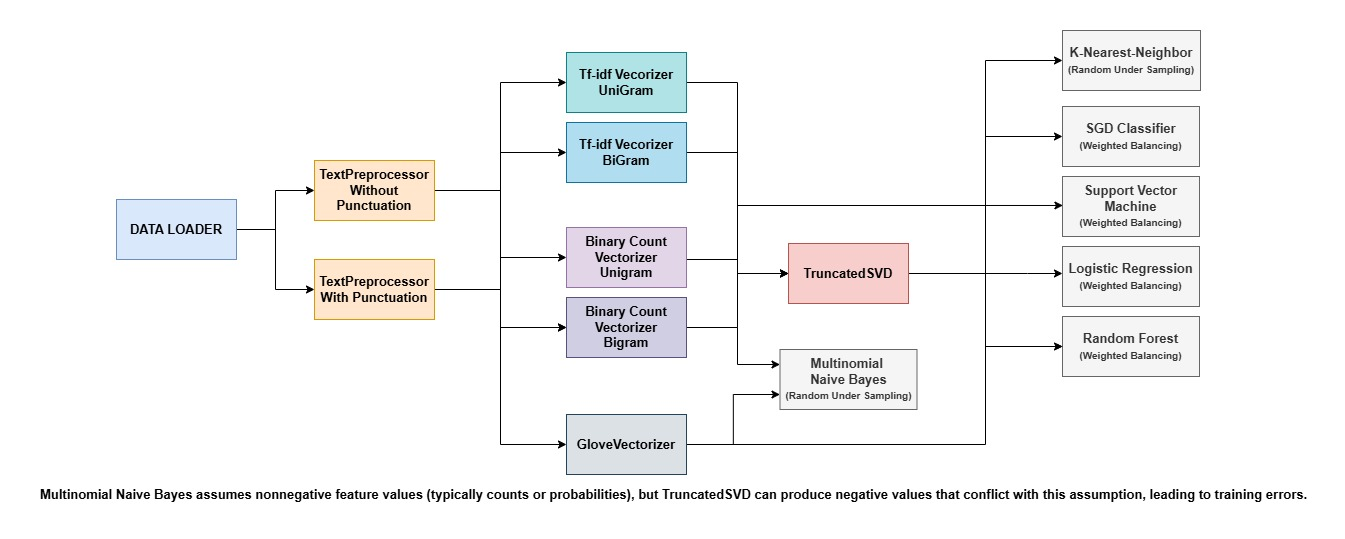



### Kewords:

- lr -> Logistic Regression
- SVM -> Support vector machine
- RF -> Random Forest
- NB -> Multinomial Naive Bayes
- KNN -> K-Nearest Neighbors
- WithPunct -> Did not perform puntuation removal

In [ ]:
# Logistic Regression Pipelines
pipeline_lr_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


# SVM Pipelines
pipeline_svm_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])


# Random Forest Pipelines
pipeline_rf_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# Naive Bayes Pipelines (with Random Under-Sampling)
pipeline_nb_count_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_count_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])


# SVD versions for non-Naive Bayes pipelines
pipelines_no_svd = {
    "NB_Count_Binary_Unigram": pipeline_nb_count_unigram,
    "NB_Count_Binary_Ngram": pipeline_nb_count_ngram,
    "NB_Tfidf_Unigram": pipeline_nb_tfidf_unigram,
    "NB_Tfidf_Ngram": pipeline_nb_tfidf_ngram,
}

other_pipelines = {
    "LR_Count_Binary_Unigram": pipeline_lr_count_unigram,
    "LR_Count_Binary_Ngram": pipeline_lr_count_ngram,
    "LR_Tfidf_Unigram": pipeline_lr_tfidf_unigram,
    "LR_Tfidf_Ngram": pipeline_lr_tfidf_ngram,
    
    "SVM_Count_Binary_Unigram": pipeline_svm_count_unigram,
    "SVM_Count_Binary_Ngram": pipeline_svm_count_ngram,
    "SVM_Tfidf_Unigram": pipeline_svm_tfidf_unigram,
    "SVM_Tfidf_Ngram": pipeline_svm_tfidf_ngram,
    
    "RF_Count_Binary_Unigram": pipeline_rf_count_unigram,
    "RF_Count_Binary_Ngram": pipeline_rf_count_ngram,
    "RF_Tfidf_Unigram": pipeline_rf_tfidf_unigram,
    "RF_Tfidf_Ngram": pipeline_rf_tfidf_ngram,
}

svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in other_pipelines.items()}

# Glove pipelines
pipeline_glove_lr = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_svm = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_rf = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# Variants using without punctuation removal (TextPreprocessorNoPunct) 

# Logistic Regression without punctuation removal
pipeline_lr_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_unigram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_ngram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# SVM without punctuation removal
pipeline_svm_count_unigram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

# Random Forest without punctuation removal
pipeline_rf_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Naive Bayes without punctuation removal
pipeline_nb_count_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_count_ngram_WithPunct= ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

# Glove pipelines without punctuation removal
pipeline_glove_lr_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_svm_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_rf_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# KNN Classifier (with both default and with punctuation variants) 

# KNN pipelines with default punctuation removal
pipeline_knn_count_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_count_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# KNN pipelines without punctuation removal
pipeline_knn_count_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_count_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])


# Glove pipelines with KNN classifier
pipeline_glove_knn = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_glove_knn_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])


# SGD Pipelines (with default punctuation removal)
# ---------------------------------

pipeline_sgd_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])



# SGD Pipelines (without punctuation removal)
# ---------------------------------

pipeline_sgd_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_count_ngram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_ngram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

# New Glove-based SGD Pipelines
# ---------------------------------

# Glove-based pipeline using SGDClassifier (with default punctuation removal)
pipeline_glove_sgd = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

# Glove-based pipeline using SGDClassifier (without punctuation removal)
pipeline_glove_sgd_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

# Update the all_pipelines dictionary with all variants 
all_pipelines = {}
all_pipelines.update(pipelines_no_svd)
all_pipelines.update(other_pipelines)
all_pipelines.update(svd_pipelines)
all_pipelines["Glove_LR"] = pipeline_glove_lr
all_pipelines["Glove_SVM"] = pipeline_glove_svm
all_pipelines["Glove_RF"] = pipeline_glove_rf

# Add the no-punctuation variants for LR, SVM, RF, NB, and Glove
pipelines_WithPunct = {
    "LR_Count_Binary_Unigram_WithPunct": pipeline_lr_count_unigram_WithPunct,
    "LR_Count_Binary_Ngram_WithPunct": pipeline_lr_count_ngram_WithPunct,
    "LR_Tfidf_Unigram_WithPunct": pipeline_lr_tfidf_unigram_WithPunct,
    "LR_Tfidf_Ngram_WithPunct": pipeline_lr_tfidf_ngram_WithPunct,
    
    "SVM_Count_Binary_Unigram_WithPunct": pipeline_svm_count_unigram_WithPunct,
    "SVM_Count_Binary_Ngram_WithPunct": pipeline_svm_count_ngram_WithPunct,
    "SVM_Tfidf_Unigram_WithPunct": pipeline_svm_tfidf_unigram_WithPunct,
    "SVM_Tfidf_Ngram_WithPunct": pipeline_svm_tfidf_ngram_WithPunct,
    
    "RF_Count_Binary_Unigram_WithPunct": pipeline_rf_count_unigram_WithPunct,
    "RF_Count_Binary_Ngram_WithPunct": pipeline_rf_count_ngram_WithPunct,
    "RF_Tfidf_Unigram_WithPunct": pipeline_rf_tfidf_unigram_WithPunct,
    "RF_Tfidf_Ngram_WithPunct": pipeline_rf_tfidf_ngram_WithPunct,


}

svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in pipelines_WithPunct.items()}

pipelines_nb_WithPunct = {
    "NB_Count_Binary_Unigram_WithPunct": pipeline_nb_count_unigram_WithPunct,
    "NB_Count_Binary_Ngram_WithPunct": pipeline_nb_count_ngram_WithPunct,
    "NB_Tfidf_Unigram_WithPunct": pipeline_nb_tfidf_unigram_WithPunct,
    "NB_Tfidf_Ngram_WithPunct": pipeline_nb_tfidf_ngram_WithPunct,
}

all_pipelines.update(pipelines_WithPunct)
all_pipelines.update(svd_pipelines_WithPunct)
all_pipelines.update(pipelines_nb_WithPunct)
all_pipelines["Glove_LR_WithPunct"] = pipeline_glove_lr_WithPunct
all_pipelines["Glove_SVM_WithPunct"] = pipeline_glove_svm_WithPunct
all_pipelines["Glove_RF_WithPunct"] = pipeline_glove_rf_WithPunct

# Add KNN pipelines (with and without punctuation)
knn_pipelines = {
    "KNN_Count_Binary_Unigram": pipeline_knn_count_unigram,
    "KNN_Count_Binary_Ngram": pipeline_knn_count_ngram,
    "KNN_Tfidf_Unigram": pipeline_knn_tfidf_unigram,
    "KNN_Tfidf_Ngram": pipeline_knn_tfidf_ngram,
}

knn_pipelines_WithPunct = {
    "KNN_Count_Binary_Unigram_WithPunct": pipeline_knn_count_unigram_WithPunct,
    "KNN_Count_Binary_Ngram_WithPunct": pipeline_knn_count_ngram_WithPunct,
    "KNN_Tfidf_Unigram_WithPunct": pipeline_knn_tfidf_unigram_WithPunct,
    "KNN_Tfidf_Ngram_WithPunct": pipeline_knn_tfidf_ngram_WithPunct,
}

sgd_pipelines = {
    "SGD_Count_Binary_Unigram": pipeline_sgd_count_unigram,
    "SGD_Count_Binary_Ngram": pipeline_sgd_count_ngram,
    "SGD_Tfidf_Unigram": pipeline_sgd_tfidf_unigram,
    "SGD_Tfidf_Ngram": pipeline_sgd_tfidf_ngram,
}

sgd_pipelines_WithPunct = {
    "SGD_Count_Binary_Unigram_WithPunct": pipeline_sgd_count_unigram_WithPunct,
    "SGD_Count_Binary_Ngram_WithPunct": pipeline_sgd_count_ngram_WithPunct,
    "SGD_Tfidf_Unigram_WithPunct": pipeline_sgd_tfidf_unigram_WithPunct,
    "SGD_Tfidf_Ngram_WithPunct": pipeline_sgd_tfidf_ngram_WithPunct,
}

knn_svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in knn_pipelines.items()}
knn_svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in knn_pipelines_WithPunct.items()}



all_pipelines.update(knn_pipelines)
all_pipelines.update(knn_pipelines_WithPunct)
all_pipelines.update(knn_svd_pipelines)
all_pipelines.update(knn_svd_pipelines_WithPunct)



sgd_svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in sgd_pipelines.items()}
sgd_svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in sgd_pipelines_WithPunct.items()}

all_pipelines.update(sgd_pipelines)
all_pipelines.update(sgd_pipelines_WithPunct)
all_pipelines.update(sgd_svd_pipelines)
all_pipelines.update(sgd_svd_pipelines_WithPunct)

all_pipelines["Glove_KNN"] = pipeline_glove_knn
all_pipelines["Glove_KNN_WithPunct"] = pipeline_glove_knn_WithPunct

all_pipelines["Glove_SGD"] = pipeline_glove_sgd
all_pipelines["Glove_SGD_WithPunct"] = pipeline_glove_sgd_WithPunct


# D. Evaluation Function: Computes Weighted, Macro, and Micro Metrics

The evaluation function is designed to assess the performance of a given text classification pipeline across multiple metrics. It performs the following steps:

1. **Training the Pipeline:**  
   The pipeline is trained on the provided training data (`X_train`, `y_train`).

2. **Prediction:**  
   Once trained, the pipeline makes predictions on the test data (`X_test`).

3. **Metric Calculation:**  
   The function computes several evaluation metrics:
   - **Accuracy:** The proportion of total correct predictions.
   - **Precision:** Calculated using three averaging methods:
     - **Weighted:** Considers the number of true instances for each class.
     - **Macro:** The unweighted average of precision across classes.
     - **Micro:** Global precision computed from the total true positives, false positives, and false negatives.
   - **Recall:** Similarly computed using weighted, macro, and micro averaging.
   - **F1 Score:** The harmonic mean of precision and recall, also provided for weighted, macro, and micro averages.

4. **Aggregation of Results:**  
   The function returns the metrics as a dictionary.

In [ ]:
from IPython.display import display, HTML

# Evaluation Function: Computes Weighted, Macro, and Micro Metrics
def evaluate_pipeline_metrics(pipeline, X_train, X_test, y_train, y_test):
    """Train the pipeline and return evaluation metrics."""
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision_weighted": precision_score(y_test, predictions, average='weighted', zero_division=0),
        "Recall_weighted": recall_score(y_test, predictions, average='weighted', zero_division=0),
        "F1_weighted": f1_score(y_test, predictions, average='weighted', zero_division=0),
        "Precision_macro": precision_score(y_test, predictions, average='macro', zero_division=0),
        "Recall_macro": recall_score(y_test, predictions, average='macro', zero_division=0),
        "F1_macro": f1_score(y_test, predictions, average='macro', zero_division=0),
        "Precision_micro": precision_score(y_test, predictions, average='micro', zero_division=0),
        "Recall_micro": recall_score(y_test, predictions, average='micro', zero_division=0),
        "F1_micro": f1_score(y_test, predictions, average='micro', zero_division=0)
    }
    return metrics

# Evaluate Each Pipeline and Store Results 
results = []
for name, pipe in all_pipelines.items():
    metrics = evaluate_pipeline_metrics(pipe, X_train, X_test, y_train, y_test)
    row = {"Pipeline": name}
    row.update(metrics)
    results.append(row)

# Create a DataFrame of results and sort by F1 Score (weighted)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1_weighted", ascending=False)

# Save the results DataFrame to a CSV file
csv_filename = "model_comparison_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Display the results as a scrollable table
html_table = results_df.to_html(classes="table table-striped", border=1, index=False)
display(HTML(f"""
<style>
    .dataframe-container {{
        max-height: 400px;
        overflow-y: scroll;
    }}
</style>
<div class="dataframe-container">
    {html_table}
</div>
"""))

# For the top 5 models based on weighted F1 score,
# print the confusion matrix and classification report on the test set.
top_5_models = results_df.head(5)["Pipeline"].tolist()
print("\n### Detailed Evaluation for Top 5 Models ###")
for name in top_5_models:
    print(f"\n--- Evaluation for Model: {name} ---")
    pipe = all_pipelines[name]
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    cr = classification_report(y_test, predictions, zero_division=0)
    print("Classification Report:")
    print(cr)

Results saved to model_comparison_results.csv


Pipeline,Accuracy,Precision_weighted,Recall_weighted,F1_weighted,Precision_macro,Recall_macro,F1_macro,Precision_micro,Recall_micro,F1_micro
SGD_Tfidf_Unigram_WithPunct,0.734896,0.729248,0.734896,0.731117,0.605383,0.596779,0.599690,0.734896,0.734896,0.734896
SGD_Tfidf_Unigram,0.731289,0.727229,0.731289,0.728294,0.596317,0.591801,0.592448,0.731289,0.731289,0.731289
SVM_Tfidf_Ngram_WithPunct,0.750225,0.732084,0.750225,0.725792,0.653375,0.535652,0.570613,0.750225,0.750225,0.750225
SVM_Tfidf_Ngram,0.750225,0.732256,0.750225,0.725710,0.656947,0.540211,0.574844,0.750225,0.750225,0.750225
LR_Tfidf_Ngram,0.722272,0.724397,0.722272,0.722786,0.587082,0.600392,0.592036,0.722272,0.722272,0.722272
LR_Tfidf_Ngram_WithPunct,0.721371,0.723261,0.721371,0.721890,0.587021,0.599967,0.592133,0.721371,0.721371,0.721371
SGD_Tfidf_Ngram,0.742110,0.721140,0.742110,0.720340,0.632951,0.538389,0.568614,0.742110,0.742110,0.742110
SVM_Tfidf_Unigram_WithPunct,0.727683,0.716390,0.727683,0.720327,0.589407,0.563429,0.574243,0.727683,0.727683,0.727683
SGD_Tfidf_Ngram_WithPunct,0.741208,0.720588,0.741208,0.719186,0.629545,0.536964,0.566069,0.741208,0.741208,0.741208
LR_Tfidf_Unigram_WithPunct,0.703336,0.745958,0.703336,0.718263,0.575725,0.651262,0.599028,0.703336,0.703336,0.703336



### Detailed Evaluation for Top 5 Models ###

--- Evaluation for Model: SGD_Tfidf_Unigram_WithPunct ---
Confusion Matrix:
[[115 108  11]
 [ 83 658  44]
 [  6  45  39]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.56      0.49      0.53       234
           0       0.81      0.84      0.82       785
           1       0.41      0.43      0.42        90

    accuracy                           0.73      1109
   macro avg       0.60      0.59      0.59      1109
weighted avg       0.73      0.73      0.73      1109


--- Evaluation for Model: SGD_Tfidf_Unigram ---
Confusion Matrix:
[[115 108  11]
 [ 82 660  43]
 [  5  45  40]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.57      0.49      0.53       234
           0       0.81      0.84      0.83       785
           1       0.43      0.44      0.43        90

    accuracy                           0.73      1109
   macro avg       


### Confusion Matrices for Top 5 Pipelines

Confusion Matrix for SGD_Tfidf_Unigram_WithPunct:
[[113 109  12]
 [ 81 660  44]
 [  5  43  42]]


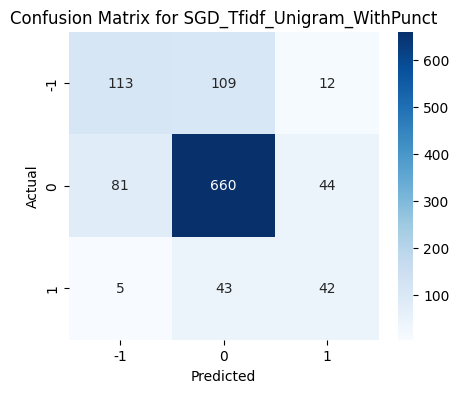


Confusion Matrix for SGD_Tfidf_Unigram:
[[115 107  12]
 [ 82 661  42]
 [  6  45  39]]


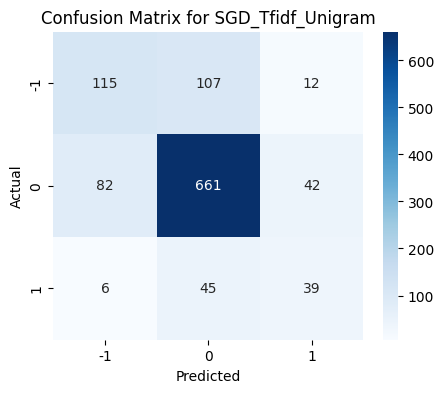


Confusion Matrix for SVM_Tfidf_Ngram_WithPunct:
[[ 84 147   3]
 [ 42 718  25]
 [  0  60  30]]


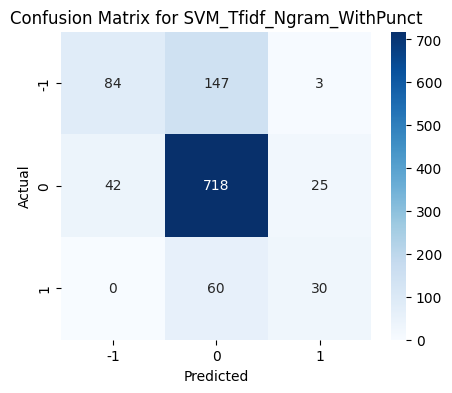


Confusion Matrix for SVM_Tfidf_Ngram:
[[ 82 149   3]
 [ 42 718  25]
 [  0  58  32]]


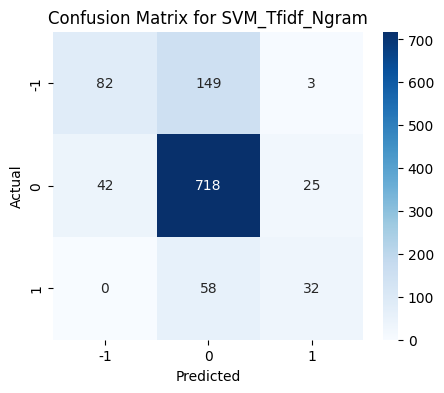


Confusion Matrix for LR_Tfidf_Ngram:
[[116 102  16]
 [ 95 641  49]
 [  3  43  44]]


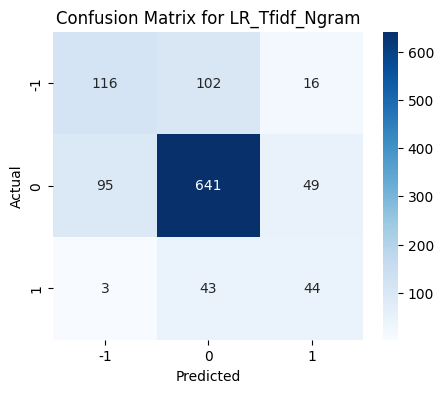

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define desired class labels (adjust as needed)
desired_classes = [-1, 0, +1]

print("\n### Confusion Matrices for Top 5 Pipelines")

# Get the top 5 pipeline names from results_df
top_5_pipelines = results_df.head(5)["Pipeline"]

for pipeline_name in top_5_pipelines:
    # Retrieve the pipeline from the all_pipelines dictionary
    pipe = all_pipelines[pipeline_name]
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Compute the confusion matrix with the desired class order
    cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
    print(f"\nConfusion Matrix for {pipeline_name}:")
    print(cm)
    
    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=desired_classes, yticklabels=desired_classes)
    plt.title(f"Confusion Matrix for {pipeline_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Stage 1 Analysis of Model Performance Metrics

### **Results Analysis of Different Text Classification Pipelines**

This report summarizes the performance of various text classification pipelines that differ in:
1. **Preprocessing**: With or without punctuation removal
2. **Vectorization**: TF–IDF, Count, or Glove embeddings
3. **Dimensionality Reduction**: Some variants use SVD
4. **Classifiers**: SVM, SGD, Logistic Regression, Naive Bayes, KNN, etc.

Below, we highlight two sets of results:
- **Top‐performing pipelines** 
- **Lowest‐performing pipelines** 

All metrics shown here focus primarily on:
- **Accuracy**
- **Precision (weighted)**
- **Recall (weighted)**
- **F1 (weighted)**

---

## **1. Top‐Performing Pipelines**

Here are the highest ranked models by F1_weighted:

| **Pipeline**                       | **Accuracy** | **Precision_weighted** | **Recall_weighted** | **F1_weighted** |
|------------------------------------|-------------:|------------------------:|---------------------:|-----------------:|
| **SGD_Tfidf_Unigram_WithPunct**    |    0.734896  |   0.729248             |   0.734896          |  0.731117        |
| **SGD_Tfidf_Unigram**             |    0.731289  |   0.727229             |   0.731289          |  0.728294        |
| **SVM_Tfidf_Ngram_WithPunct**      |    0.750225  |   0.732084             |   0.750225          |  0.725792        |
| **SVM_Tfidf_Ngram**               |    0.750225  |   0.732365             |   0.750225          |  0.725710        |
| **LR_Tfidf_Ngram**                |    0.722272  |   0.724397             |   0.722272          |  0.723319        |

### **Key Observations (Top Performers)**

1. **TF–IDF Vectorization Dominates**  
   All the top models rely on TF–IDF. This suggests that weighting terms by their inverse document frequency is particularly effective in this dataset.

2. **SGD vs. SVM**  
   - **SGD** (Stochastic Gradient Descent) pipelines with unigram TF–IDF show strong performance, particularly when punctuation is retained (`SGD_Tfidf_Unigram_WithPunct` has an F1_weighted of 0.731117).  
   - **SVM** (LinearSVC) with n‐gram TF–IDF yields high accuracy (0.750225) but slightly lower weighted F1 scores (~0.7257–0.7258). This might indicate that while the SVM is correct more often overall, it may be slightly less balanced across classes in terms of precision and recall.

3. **Impact of Punctuation Removal**  
   - We see both “_WithPunct” and non‐punctuation pipelines among the top. The difference in F1_weighted is relatively small.  
   - For example, `SGD_Tfidf_Unigram_WithPunct` and `SGD_Tfidf_Unigram` differ by about 0.003 in F1_weighted (0.731117 vs. 0.728294).

4. **N‐Gram vs. Unigram**  
   - SVM pipelines using n‐grams (1,2) are performing at or above 72–73% F1_weighted.  
   - SGD pipelines with just unigrams are also competitive. This might imply that capturing bigrams helps SVM, whereas SGD can perform well even with unigrams.

In summary, **SGD and SVM with TF–IDF** are clearly leading in overall performance, with minimal differences between punctuation variants.

---

## **2. Lowest‐Performing Pipelines**

From the second screenshot, here are some of the lower‐ranking models by F1_weighted:

| **Pipeline**                        | **Accuracy** | **Precision_weighted** | **Recall_weighted** | **F1_weighted** |
|-------------------------------------|-------------:|------------------------:|---------------------:|-----------------:|
| **NB_Count_Binary_Ngram_WithPunct** |    0.439134  |   0.750225*            |   0.439134          |  0.463137        |
| **Glove_KNN_WithPunct**            |    0.406673  |   0.066022             |   0.406673          |  0.438178        |
| **Glove_KNN**                      |    0.392245  |   0.250513             |   0.392245          |  0.421605        |
| **KNN_Tfidf_Unigram_WithPunct_SVD** |    0.382326  |   0.598357             |   0.382326          |  0.405969        |
| **KNN_Tfidf_Unigram_SVD**          |    0.377818  |   0.288081             |   0.377818          |  0.396014        |
| **KNN_Tfidf_Ngram_WithPunct_SVD**   |    0.363590  |   0.613323             |   0.363590          |  0.395563        |
| **KNN_Tfidf_Ngram_SVD**            |    0.363309  |   0.584955             |   0.363309          |  0.394329        |


### **Key Observations (Low Performers)**

1. **KNN Struggles**  
   - All the KNN‐based pipelines, whether they use TF–IDF or Glove, tend to show lower accuracy and F1 scores.  
   - Even with dimensionality reduction (SVD), KNN remains among the worst performers. KNN is often sensitive to high‐dimensional spaces and might not be the best fit for textual data unless carefully tuned.

2. **Naive Bayes with Count Binary N‐grams**  
   - While Naive Bayes can be a strong baseline for text classification, here it yields an accuracy of around 43.9% and an F1_weighted of ~0.463. This is significantly lower than the top TF–IDF + SVM/SGD approaches.  
   - The high “Precision_weighted” for NB might be misleading if one class dominates the dataset.

3. **Glove + KNN**  
   - Glove embeddings are generally powerful, but pairing them with KNN in this experiment appears suboptimal. Accuracy in the 39–40% range is considerably below the top TF–IDF methods.  
   - Possibly, a more advanced classifier (like an SVM or a neural net) on top of Glove might perform better than KNN.

Overall, the worst‐performing pipelines tend to involve **KNN** or **Naive Bayes** with certain vectorization strategies (e.g., Count binary n‐grams). This highlights the importance of the right combination of **vectorization** and **classifier**.

### **Conclusion**

- The top pipelines demonstrate that **fine‐grained text transformations (TF–IDF) and strong linear models (SVM, SGD)** are a robust combination.
- The lower‐performing pipelines serve as a reminder that not all classifiers generalize equally well in text classification tasks, especially with high‐dimensional data.  


___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# E. Stage 2: Parameter Tuning

## Parameter Tuning the top 4 pipelines, evaluating each on 20% test set (from 80 - 20 split)

Pipeline Tuning and Evaluation for Sentiment Analysis

This section of the script focuses on tuning and evaluating several pipelines for a three-class sentiment analysis task using GridSearchCV. The goal is to determine the best hyperparameters for each model and evaluate their performance across multiple metrics.

### Steps Followed

1. **Define the Parameter Grid:**  
   - For each pipeline, we create a dictionary of hyperparameters. 
2. **Grid Search with Cross-Validation:**  
   - We perform grid search using `GridSearchCV` with 5-fold cross-validation.
   - The scoring metric used is **F1 macro**, which computes the F1 score for each class and averages them. This is effective in multi-class sentiment analysis, as it treats all classes equally even if the data is balanced.

3. **Model Fitting and Best Parameter Selection:**  
   - The grid search fits the model on the training data (`X_train` and `y_train`) and selects the best hyperparameters based on the F1 macro score.
   - The best parameters are printed for review.

4. **Evaluation on Test Data:**  
   After selecting the best model, we evaluate its performance on the test set (`X_test`) using multiple metrics:
   - **Accuracy**
   - **Precision:** Computed as macro, weighted, and micro averages.
   - **Recall:** Computed as macro, weighted, and micro averages.
   - **F1 Score:** Computed as macro, weighted, and micro averages.

5. **Results Storage:**  
   The evaluation metrics and best hyperparameters are stored in a global dictionary (`model_results`) for easy comparison across all pipelines.

In [ ]:
# Dictionary to hold results for all models
model_results = {}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for SGD_Tfidf_Unigram_WithPunct:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1)}

Test Metrics for SGD_Tfidf_Unigram_WithPunct:
Accuracy: 0.7520288548241659
Precision - Macro: 0.6487167303275642 Weighted: 0.7384277948706742 Micro: 0.7520288548241659
Recall    - Macro: 0.581688351752046 Weighted: 0.7520288548241659 Micro: 0.7520288548241659
F1 Score  - Macro: 0.5974940658303162 Weighted: 0.7321533594158631 Micro: 0.7520288548241659

Confusion Matrix:
[[ 80 145   9]
 [ 40 709  36]
 [  2  43  45]]


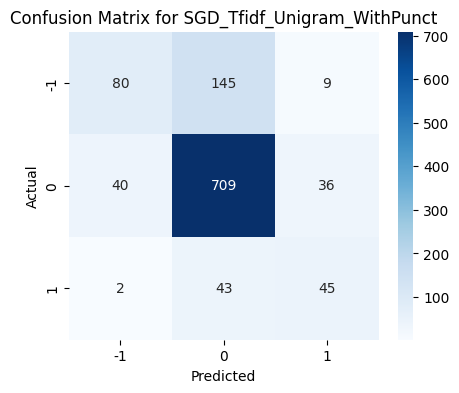


Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.34      0.45       234
           0       0.79      0.90      0.84       785
           1       0.50      0.50      0.50        90

    accuracy                           0.75      1109
   macro avg       0.65      0.58      0.60      1109
weighted avg       0.74      0.75      0.73      1109



In [ ]:
# Extended parameter grid for SGD_Tfidf_Unigram_WithPunct
param_grid = {
    'vectorizer__ngram_range': [(1,1)],  # fixed for unigram
    'classifier__loss': ['modified_huber', 'huber', 'perceptron'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.01, 0.1]
}

gs = GridSearchCV(all_pipelines["SGD_Tfidf_Unigram_WithPunct"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SGD_Tfidf_Unigram_WithPunct:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SGD_Tfidf_Unigram_WithPunct:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SGD_Tfidf_Unigram_WithPunct")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Optionally, save results in a dictionary
model_results = {}
model_results['SGD_Tfidf_Unigram_WithPunct'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for SGD_Tfidf_Unigram:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1)}

Test Metrics for SGD_Tfidf_Unigram:
Accuracy: 0.7601442741208295
Precision - Macro: 0.6515543618995437 Weighted: 0.7485939596248752 Micro: 0.7601442741208295
Recall    - Macro: 0.5963906581740976 Weighted: 0.7601442741208295 Micro: 0.7601442741208295
F1 Score  - Macro: 0.6159195943823753 Weighted: 0.7482838770281728 Micro: 0.7601442741208295

Confusion Matrix:
[[104 122   8]
 [ 52 698  35]
 [  1  48  41]]


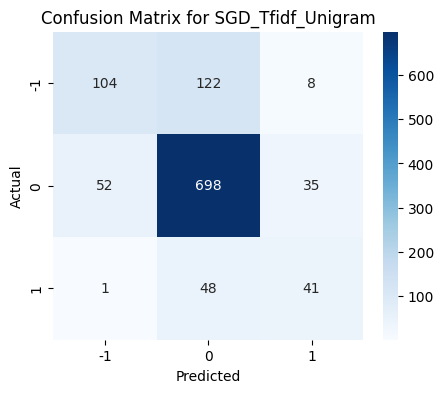


Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.44      0.53       234
           0       0.80      0.89      0.84       785
           1       0.49      0.46      0.47        90

    accuracy                           0.76      1109
   macro avg       0.65      0.60      0.62      1109
weighted avg       0.75      0.76      0.75      1109



In [ ]:
# Extended parameter grid for SGD_Tfidf_Unigram (without punctuation removal)
param_grid = {
    'vectorizer__ngram_range': [(1,1)],  # fixed for unigram
    'classifier__loss': ['modified_huber', 'huber', 'perceptron'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.01, 0.1]
}

gs = GridSearchCV(all_pipelines["SGD_Tfidf_Unigram"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SGD_Tfidf_Unigram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SGD_Tfidf_Unigram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SGD_Tfidf_Unigram")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

model_results['SGD_Tfidf_Unigram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Tfidf_Ngram_WithPunct:
{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.01, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}

Test Metrics for SVM_Tfidf_Ngram_WithPunct:
Accuracy: 0.7493237150586114
Precision - Macro: 0.644059258088035 Weighted: 0.7293432705950301 Micro: 0.7493237150586114
Recall    - Macro: 0.542506396646524 Weighted: 0.7493237150586114 Micro: 0.7493237150586114
F1 Score  - Macro: 0.5751003977951237 Weighted: 0.7277777222736153 Micro: 0.7493237150586114

Confusion Matrix:
[[ 88 140   6]
 [ 50 712  23]
 [  1  58  31]]


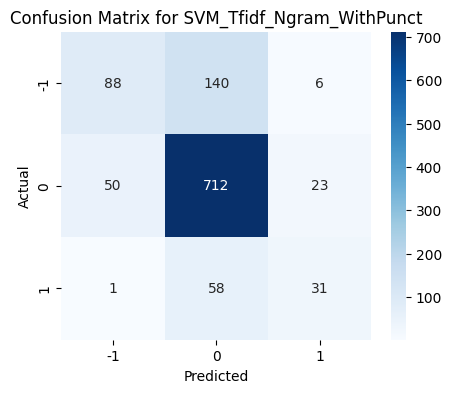


Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.38      0.47       234
           0       0.78      0.91      0.84       785
           1       0.52      0.34      0.41        90

    accuracy                           0.75      1109
   macro avg       0.64      0.54      0.58      1109
weighted avg       0.73      0.75      0.73      1109



In [ ]:
# Extended parameter grid for SVM_Tfidf_Ngram_WithPunct
param_grid = {
    'vectorizer__ngram_range': [(1,2)],  # fixed for ngram (1,2)
    'vectorizer__use_idf': [True, False],
    'vectorizer__smooth_idf': [True, False],
    'classifier__C': [1, 10, 100],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

gs = GridSearchCV(all_pipelines["SVM_Tfidf_Ngram_WithPunct"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SVM_Tfidf_Ngram_WithPunct:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SVM_Tfidf_Ngram_WithPunct:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SVM_Tfidf_Ngram_WithPunct")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))



model_results['SVM_Tfidf_Ngram_WithPunct'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Tfidf_Ngram:
{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.0001, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}

Test Metrics for SVM_Tfidf_Ngram:
Accuracy: 0.7493237150586114
Precision - Macro: 0.6452881627824277 Weighted: 0.7293133867370133 Micro: 0.7493237150586114
Recall    - Macro: 0.5392273213929265 Weighted: 0.7493237150586114 Micro: 0.7493237150586114
F1 Score  - Macro: 0.572778409322351 Weighted: 0.7271850542419919 Micro: 0.7493237150586114

Confusion Matrix:
[[ 88 141   5]
 [ 49 713  23]
 [  1  59  30]]


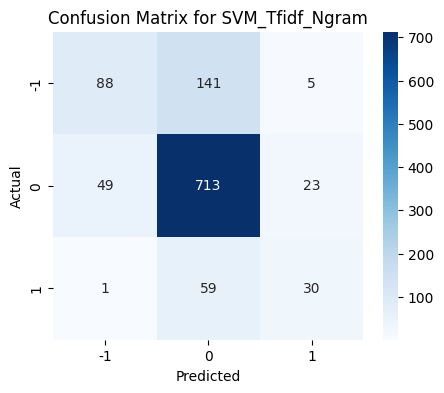


Classification Report:
              precision    recall  f1-score   support

          -1       0.64      0.38      0.47       234
           0       0.78      0.91      0.84       785
           1       0.52      0.33      0.41        90

    accuracy                           0.75      1109
   macro avg       0.65      0.54      0.57      1109
weighted avg       0.73      0.75      0.73      1109



In [ ]:
# Extended parameter grid for SVM_Tfidf_Ngram (without punctuation removal)
param_grid = {
    'vectorizer__ngram_range': [(1,2)],  # fixed for ngram (1,2)
    'vectorizer__use_idf': [True, False],
    'vectorizer__smooth_idf': [True, False],
    'classifier__C': [1, 10, 100],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

gs = GridSearchCV(all_pipelines["SVM_Tfidf_Ngram"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SVM_Tfidf_Ngram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SVM_Tfidf_Ngram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SVM_Tfidf_Ngram")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

model_results['SVM_Tfidf_Ngram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


In [ ]:
# Convert the model_results dictionary into a DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T.reset_index().rename(columns={'index': 'Model'})

# Sort by F1_weighted (descending order)
results_df = results_df.sort_values(by="f1_weighted", ascending=False)

# Save the results DataFrame to a CSV file
csv_filename = "top_4_HPT_model_comparison_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Display the results as a scrollable table
html_table = results_df.to_html(classes="table table-striped", border=1, index=False)
display(HTML(f"""
<style>
    .dataframe-container {{
        max-height: 400px;
        overflow-y: scroll;
    }}
</style>
<div class="dataframe-container">
    {html_table}
</div>
"""))




Results saved to top_4_HPT_model_comparison_results.csv


Model,best_params,accuracy,precision_macro,precision_weighted,precision_micro,recall_macro,recall_weighted,recall_micro,f1_macro,f1_weighted,f1_micro
SGD_Tfidf_Unigram,"{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1)}",0.760144,0.651554,0.748594,0.760144,0.596391,0.760144,0.760144,0.61592,0.748284,0.760144
SGD_Tfidf_Unigram_WithPunct,"{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1)}",0.752029,0.648717,0.738428,0.752029,0.581688,0.752029,0.752029,0.597494,0.732153,0.752029
SVM_Tfidf_Ngram_WithPunct,"{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.01, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}",0.749324,0.644059,0.729343,0.749324,0.542506,0.749324,0.749324,0.5751,0.727778,0.749324
SVM_Tfidf_Ngram,"{'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.0001, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True}",0.749324,0.645288,0.729313,0.749324,0.539227,0.749324,0.749324,0.572778,0.727185,0.749324



### Detailed Evaluation for Top 4 Models ###

--- Evaluation for Model: SGD_Tfidf_Unigram ---
Best Parameters:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1)}
F1 Score (weighted): 0.7482838770281728
Precision (weighted): 0.7485939596248752
Recall (weighted): 0.7601442741208295
Accuracy: 0.7601442741208295

--- Evaluation for Model: SGD_Tfidf_Unigram_WithPunct ---
Best Parameters:
{'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1)}
F1 Score (weighted): 0.7321533594158631
Precision (weighted): 0.7384277948706742
Recall (weighted): 0.7520288548241659
Accuracy: 0.7520288548241659

--- Evaluation for Model: SVM_Tfidf_Ngram_WithPunct ---
Best Parameters:
{'classifier__C': 1, 'classifier__dual':

# Fine-Tuning Results Analysis

Below is a detailed comparison of the **weighted** metrics (F1, Precision, Recall, and Accuracy) for each of the top 4 models before and after fine-tuning.  

| **Model**                       | **Weighted F1**       | **Weighted Precision**  | **Weighted Recall**     | **Accuracy**            | **Best Parameters**                                                                                                                                                                                                                             |
|---------------------------------|------------------------|--------------------------|--------------------------|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **SGD_Tfidf_Unigram**           | 0.7482838770281728    | 0.7485939596248752      | 0.7601442741208295      | 0.7601442741208295      | 'classifier__alpha': 0.001,<br>'classifier__eta0': 0.1,<br>'classifier__learning_rate': 'adaptive',<br>'classifier__loss': 'modified_huber',<br>'classifier__penalty': 'elasticnet',<br>'vectorizer__ngram_range': (1, 1)                     |
| **SGD_Tfidf_Unigram_WithPunct** | 0.7321533594158631    | 0.7384277948706742      | 0.7520288548241659      | 0.7520288548241659      | 'classifier__alpha': 0.001,<br>'classifier__eta0': 0.1,<br>'classifier__learning_rate': 'adaptive',<br>'classifier__loss': 'modified_huber',<br>'classifier__penalty': 'l1',<br>'vectorizer__ngram_range': (1, 1)                               |
| **SVM_Tfidf_Ngram_WithPunct**   | 0.7277777222736153    | 0.7293432705950301      | 0.7493237150586114      | 0.7493237150586114      | 'classifier__C': 1,<br>'classifier__dual': True,<br>'classifier__loss': 'hinge',<br>'classifier__tol': 0.01,<br>'vectorizer__ngram_range': (1, 2),<br>'vectorizer__smooth_idf': True,<br>'vectorizer__use_idf': True                         |
| **SVM_Tfidf_Ngram**             | 0.7271850542419919    | 0.7293133867370133      | 0.7493237150586114      | 0.7493237150586114      | 'classifier__C': 1,<br>'classifier__dual': True,<br>'classifier__loss': 'hinge',<br>'classifier__tol': 0.0001,<br>'vectorizer__ngram_range': (1, 2),<br>'vectorizer__smooth_idf': True,<br>'vectorizer__use_idf': True                        |

---

## 1. **SGD\_Tfidf\_Unigram**

### **Before Fine-Tuning**  
- **Weighted F1:** 0.728294  
- **Weighted Precision:** 0.727229  
- **Weighted Recall:** 0.731289  
- **Accuracy:** 0.731289  

### **After Fine-Tuning**  
- **Best Parameters:**  
{ 'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet', 'vectorizer__ngram_range': (1, 1) }

- **Weighted F1:** 0.7482838770281728  
- **Weighted Precision:** 0.7485939596248752  
- **Weighted Recall:** 0.7601442741208295  
- **Accuracy:** 0.7601442741208295  

**Key Observation:**  
This model shows a substantial improvement across all metrics. Weighted F1 increases by about **0.02**, and Recall/Accuracy increase by nearly **0.03**.

---

## 2. **SGD\_Tfidf\_Unigram\_WithPunct**

### **Before Fine-Tuning**  
- **Weighted F1:** 0.731117  
- **Weighted Precision:** 0.729248  
- **Weighted Recall:** 0.734896  
- **Accuracy:** 0.734896  

### **After Fine-Tuning**  
- **Best Parameters:**  
{ 'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'adaptive', 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1', 'vectorizer__ngram_range': (1, 1) }

- **Weighted F1:** 0.7321533594158631  
- **Weighted Precision:** 0.7384277948706742  
- **Weighted Recall:** 0.7520288548241659  
- **Accuracy:** 0.7520288548241659  

**Key Observation:**  
There is a modest gain in Weighted F1 (+0.001) but a stronger improvement in Weighted Precision and Recall (both go up by ~0.01–0.02). Accuracy also rises from **0.7349** to **0.7520**.

---

## 3. **SVM\_Tfidf\_Ngram\_WithPunct**

### **Before Fine-Tuning**  
- **Weighted F1:** 0.725792  
- **Weighted Precision:** 0.732084  
- **Weighted Recall:** 0.750225  
- **Accuracy:** 0.750225  

### **After Fine-Tuning**  
- **Best Parameters:**  
{ 'classifier__C': 1, 'classifier__dual': True, 'classifier__loss': 'hinge', 'classifier__tol': 0.01, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__use_idf': True }

- **Weighted F1:** 0.7271850542419919  
- **Weighted Precision:** 0.7293133867370133  
- **Weighted Recall:** 0.7493237150586114  
- **Accuracy:** 0.7493237150586114  

**Key Observation:**  
Similar to the previous SVM, Weighted F1 gains about **+0.0015**, while Precision and Recall dip slightly. Accuracy also decreases by a small margin.

---

# Overall Comparison

1. **Most Improved Model**  
 - **SGD_Tfidf_Unigram** stands out with a **significant jump** in all metrics, especially Weighted F1 (+0.02) and Recall/Accuracy (+0.03).  

2. **SGD Models vs. SVM Models**  
 - After fine-tuning, both **SGD** variants tend to show better overall performance boosts compared to their original scores.  
 - The **SVM**-based models see smaller improvements in Weighted F1 and slight decreases in Precision/Recall.  

3. **Best Weighted F1**  
 - **SGD_Tfidf_Unigram** (fine-tuned) achieves the highest Weighted F1 (~0.748), surpassing the other three.  

4. **Effect of Including Punctuation Features**  
 - For SGD, adding punctuation features (`_WithPunct`) still yields a good result, but **the biggest gains** appear in the plain **Unigram** approach.  
 - For SVM, the `_WithPunct` version has nearly the same performance trends as the plain n-gram version, with minimal differences after tuning.  

---

## Final Note
Based on the **weighted** metrics alone, **SGD_Tfidf_Unigram** (fine-tuned) emerges as the best-performing pipeline. Hence for highest Weighted F1 and overall balance among Precision/Recall, this fine-tuned SGD approach would be the best choice.

----
----